# Credit Scorecard Notebook
- Author: Marcellinus Aditya Witarsah
- Date: 19 May 2024

In [23]:
# Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import logging
import time
from pathlib import Path
from abc import ABC
from abc import abstractmethod
from scipy import stats
from typing import Tuple
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from optbinning import Scorecard
from optbinning import BinningProcess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# About the Data
Table information about the dataset from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).
|      **Feature Name**      |               **Description**               |
|:--------------------------:|:-------------------------------------------:|
| person_age                 | Age                                         |
| person_income              | Annual Income                               |
| person_home_ownership      | Home ownership                              |
| person_emp_length          | Employment length (in years)                |
| loan_intent                | Loan intent                                 |
| loan_grade                 | Loan grade                                  |
| loan_amnt                  | Loan amount                                 |
| loan_int_rate              | Interest rate                               |
| loan_status                | Loan status (0 is non default 1 is default) |
| loan_percent_income        | Percent income                              |
| cb_person_default_on_file  | Historical default                          |
| cb_preson_cred_hist_length | Credit history length                       |

# Load Data

In [5]:
log_fmt = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)

class DataIngestionStrategy(ABC):
    @abstractmethod
    def ingest_data(self, paths: list):
        pass

class PandasDataIngestionStrategy(DataIngestionStrategy):
    def ingest_data(self, paths: list) -> pd.DataFrame:
        df = pd.DataFrame({})
        for path in paths:
            path = Path(path)
            logger.info(f"Loading {path}")
            start = time.perf_counter()
            if path.suffix == ".csv":
                temp_df = pd.read_csv(path)
            elif path.suffix == ".parquet":
                temp_df = pd.read_parquet(path)
            logger.info(f"Loading data finished. Duration: {time.perf_counter() - start} s")
            df = pd.concat([df, temp_df], axis=0)
        return df

class PolarsDataIngestionStrategy(DataIngestionStrategy):
    def ingest_data(self, paths: list) -> pl.LazyFrame:
        df = None
        for path in paths:
            path = Path(path)
            logger.info(f"Loading {path}")
            start = time.perf_counter()
            if path.suffix == ".csv":
                temp_df = pl.scan_csv(path)
            elif path.suffix == ".parquet":
                temp_df = pl.scan_parquet(path)
            logger.info(f"Loading data finished. Duration: {time.perf_counter() - start} s")
            if df is None:
                df = temp_df
            else:
                df = pl.concat([df, temp_df], how="vertical")
        return df


class DataIngestion:
    @staticmethod
    def ingest_data(paths: str, strategy: DataIngestionStrategy):
        try:
            logging.info(f"Load data using {strategy.__class__.__name__}")
            return strategy.ingest_data(paths)
        except Exception as e:
            logging.error(e)

In [6]:
# Load and inspect data
df = DataIngestion.ingest_data(
    paths=[
        "../data/raw/credit_risk_dataset.csv"
    ],
    strategy=PandasDataIngestionStrategy()
)
display(df.head())
display(df.info())
display(df.describe())

2024-05-28 15:00:47,388 - root - INFO - Load data using PandasDataIngestionStrategy
2024-05-28 15:00:47,389 - __main__ - INFO - Loading ..\data\raw\credit_risk_dataset.csv
2024-05-28 15:00:47,434 - __main__ - INFO - Loading data finished. Duration: 0.04508130000613164 s


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Exploratory Data Analysis

## Univariate Analysis

### Target Proportion

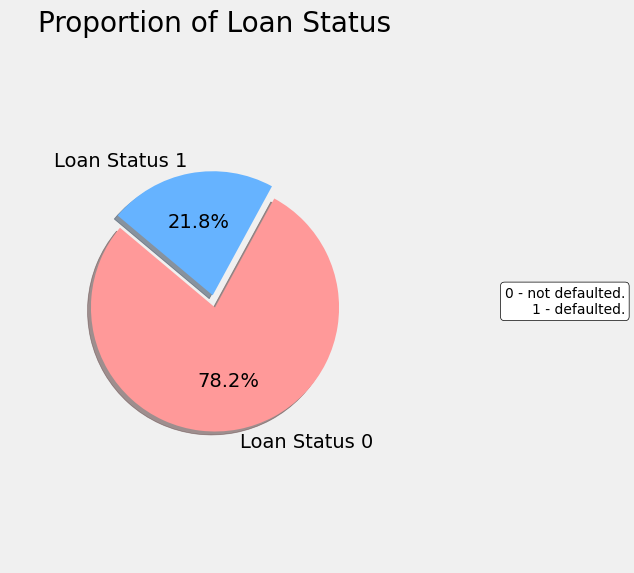

In [3]:
plt.style.use('fivethirtyeight')

# Count the values of "loan_status"
loan_status_counts = df["loan_status"].value_counts()

# Create labels and sizes for the pie chart
labels = ["Loan Status 0", "Loan Status 1"]
sizes = [loan_status_counts[0], loan_status_counts[1]]
colors = ["#ff9999","#66b3ff"]
explode = (0.1, 0)  # explode the 1st slice (Loan Status 0)

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title("Proportion of Loan Status")

# Add annotation
annotation = (
    "0 - not defaulted.\n"
    "1 - defaulted."
)
plt.annotate(annotation, xy=(1, 0.5), xytext=(1.5, 0.5),
    textcoords="axes fraction", ha="right", va="center", fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Show the plot
plt.tight_layout()
plt.show()

### Missing Values

In [4]:
# Count percentage missing values
missing_values_count = df.isna().sum()
missing_values_count / len(df) * 100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

### Numerical

In [5]:
def plot_hist_box(df: pd.DataFrame, numerical_column: str) -> None:
    """
    Show distribution of numerical data by histogram plot and boxplot.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): numerical columns to be plotted
    Returns
    ------------
        None
    """
    _, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 1 row and 2 columns

    # Histogram
    df[numerical_column].hist(ax=axes[0], bins=30, edgecolor='black')
    axes[0].set_title(f"Histogram of {numerical_column}")
    axes[0].set_xlabel(numerical_column)
    axes[0].set_ylabel("Frequency")

    # Boxplot
    df.boxplot(column=numerical_column, ax=axes[1])
    axes[1].set_title(f"Boxplot of {numerical_column}")
    axes[1].set_xlabel(numerical_column)
    axes[1].set_ylabel("Value")

    # Show plots
    plt.tight_layout()
    plt.show()

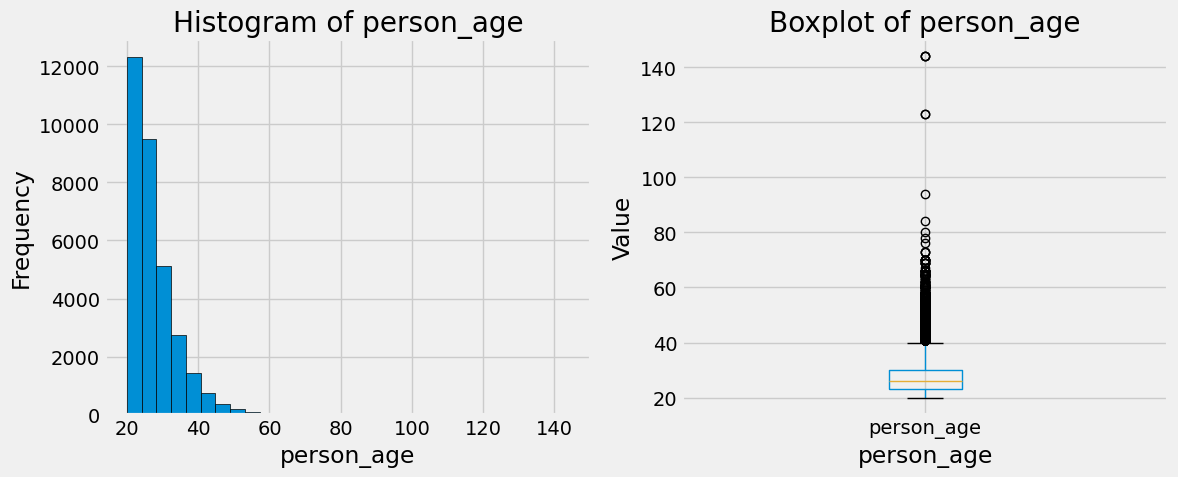

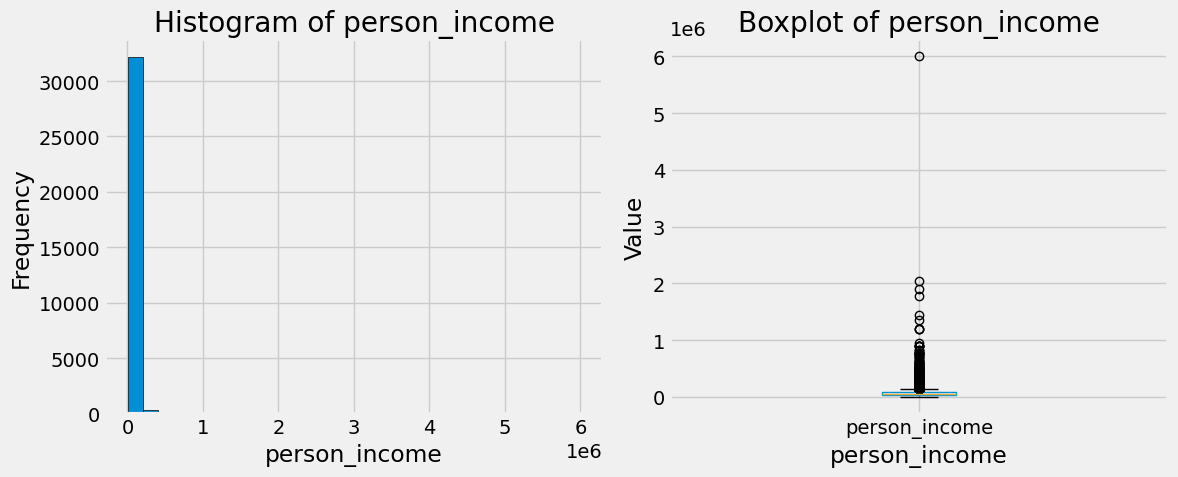

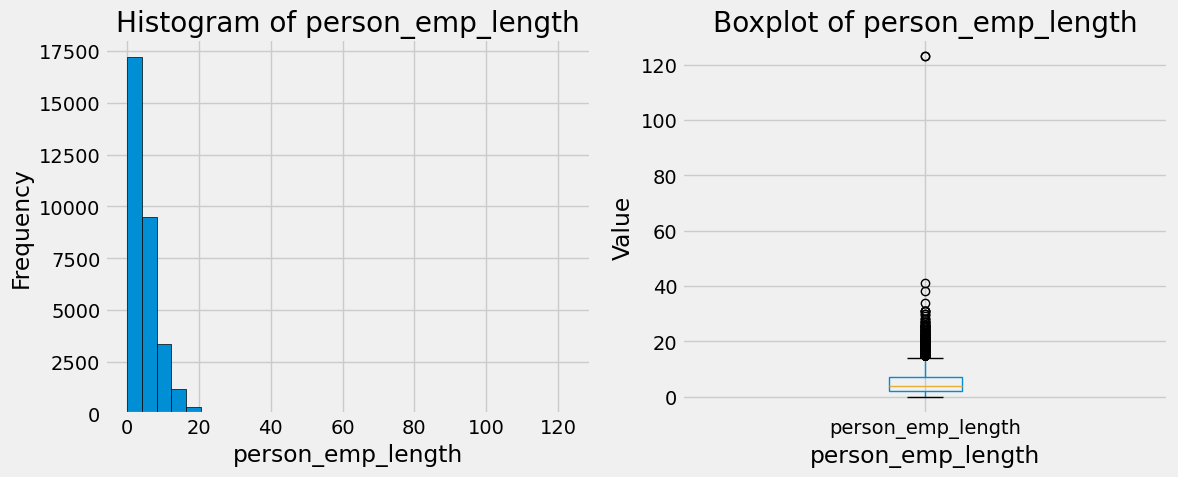

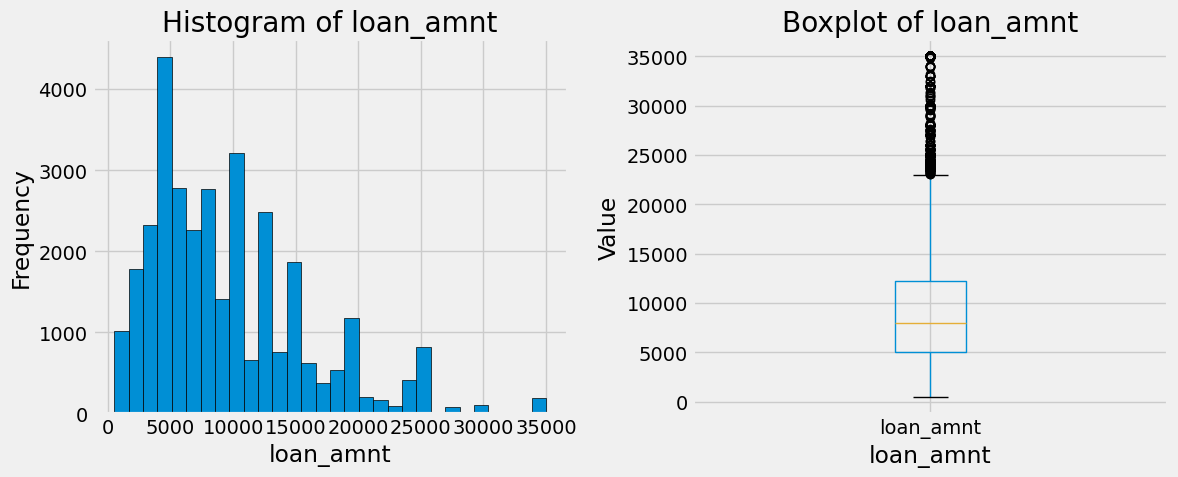

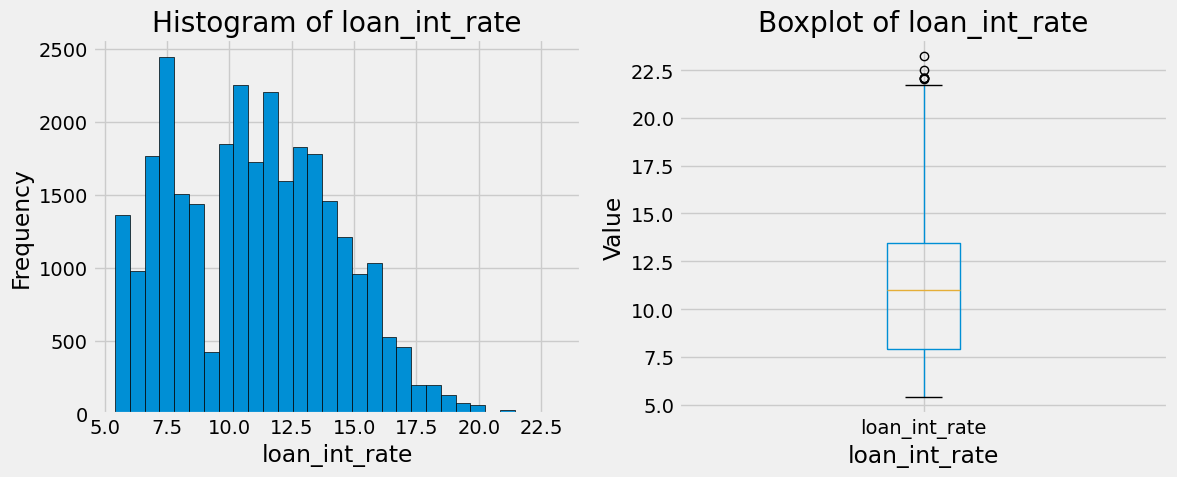

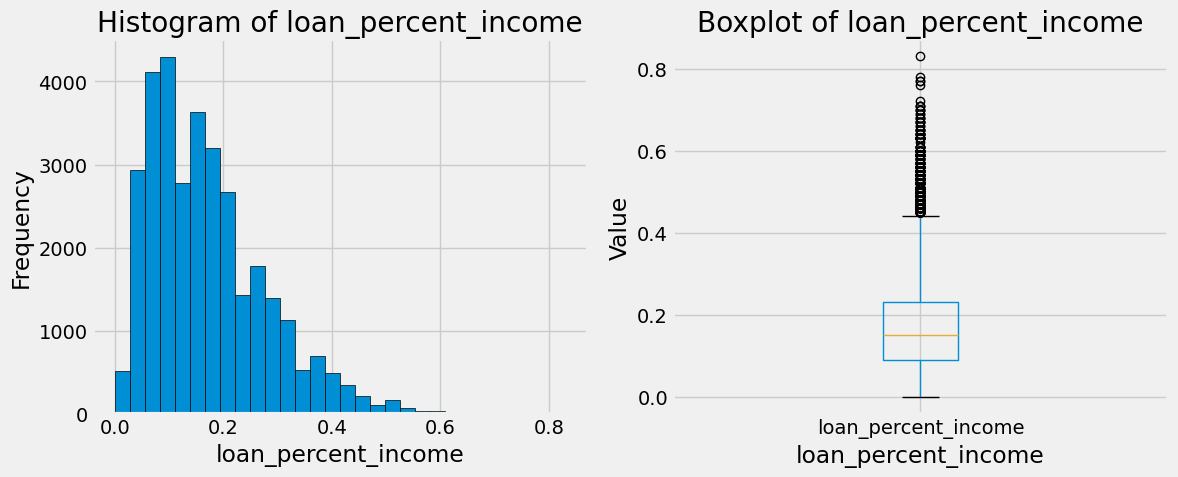

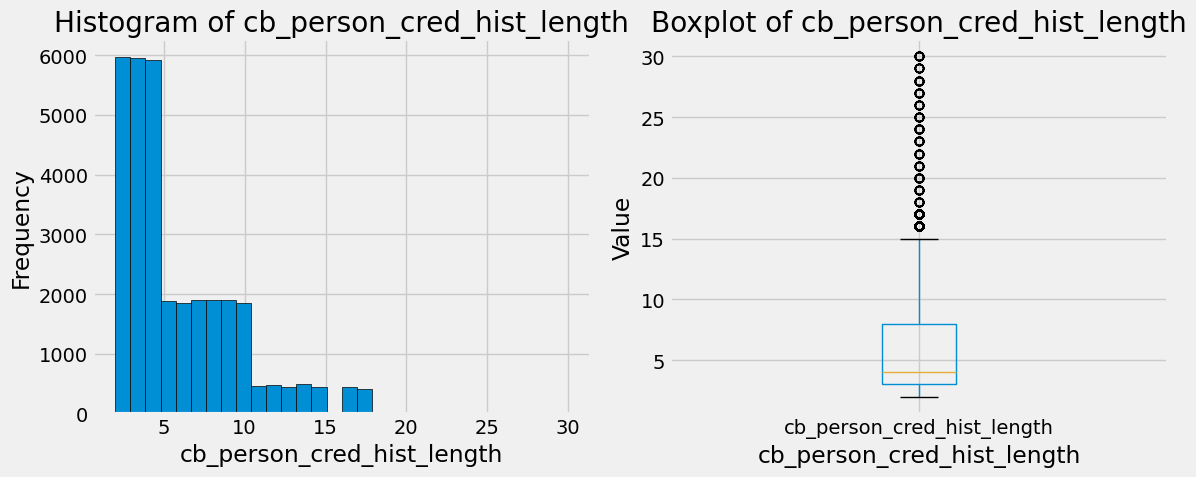

In [6]:
# Plot histogram and boxplot
numerical_columns = df.select_dtypes("number").columns  # Get the numerical columns

plt.style.use('fivethirtyeight')
for numerical_column in numerical_columns:
    if numerical_column != "loan_status":
        plot_hist_box(df, numerical_column)

Suspected outliers inside of the `person_age` where the longest people who ever lived was 122 years old.

In [7]:
df[df["person_age"] > 120]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


Looking at the data the numbers seems authentic. But in real life we might need to confirm about this.

### Categorical

In [8]:
def plot_count_categorical(df: pd.DataFrame, categorical_column: str) -> None:
    """
    Show number of occurences of each categorical column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): The numerical column to be plotted.
        categorical_column (str): categorical columns to be plotted
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=(8, 6))  # Create a figure

    # Bar plot
    df[categorical_column].value_counts().plot(kind='barh', ax=ax, edgecolor='black')
    ax.set_title(f"Count of {categorical_column}")
    ax.set_xlabel(categorical_column)
    ax.set_ylabel("Count")

    # Show plot
    plt.tight_layout()
    plt.show()

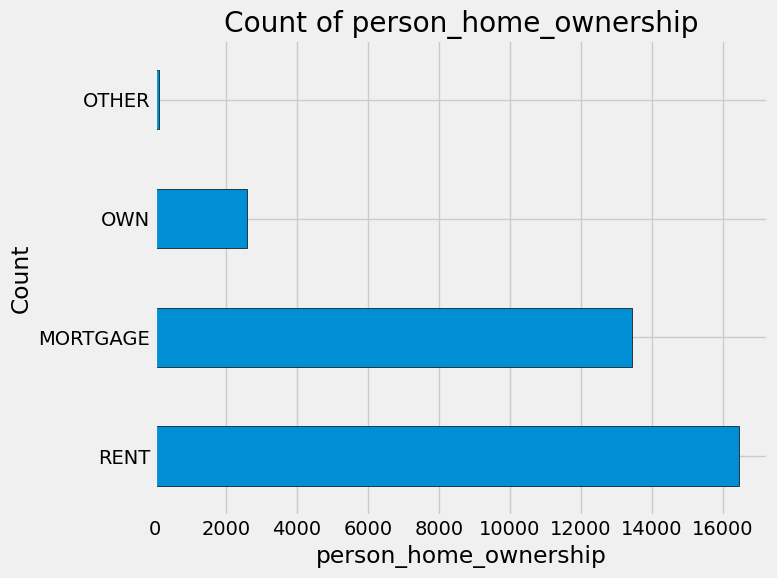

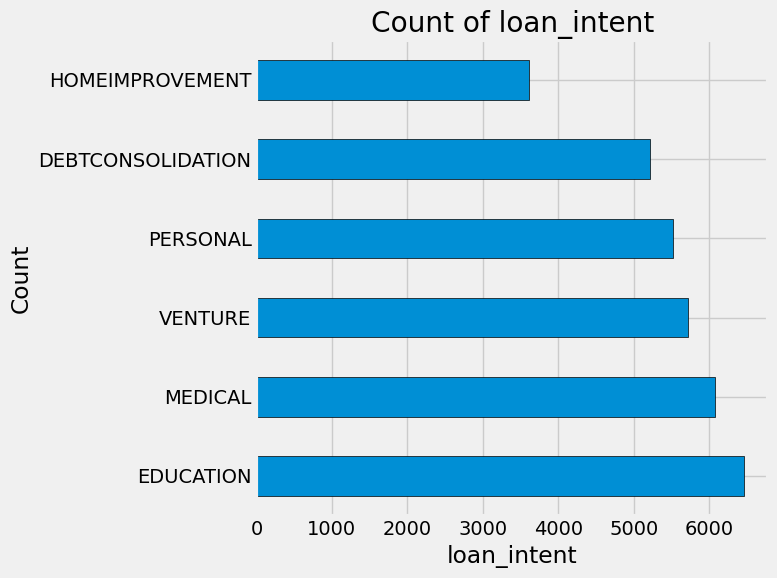

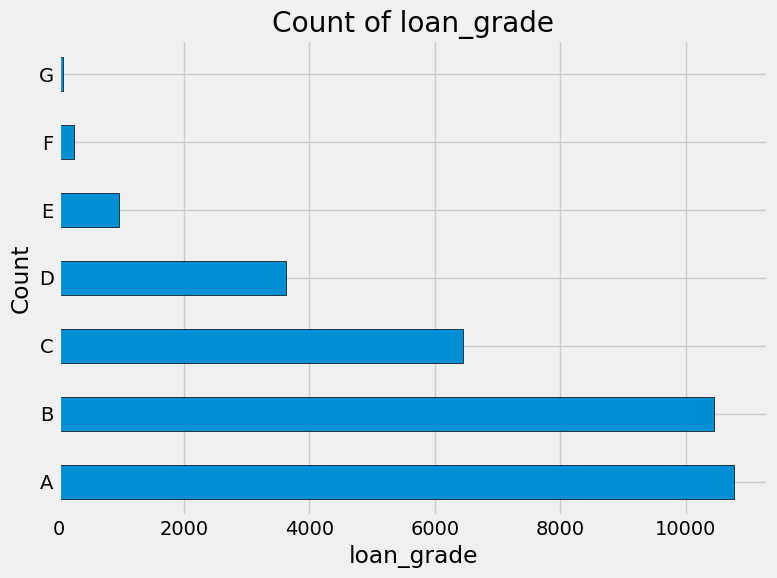

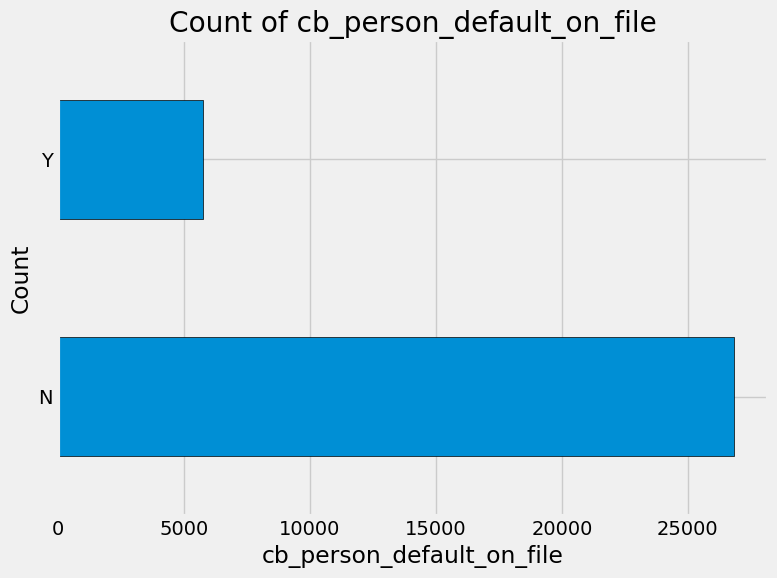

In [9]:
categorical_columns = df.select_dtypes("object").columns  # Get categorical columns

plt.style.use('fivethirtyeight')
for categorical_column in categorical_columns:
    plot_count_categorical(df, categorical_column)

## Multivariate Analysis

### Numerical vs Target

In [10]:
def plot_dist_numerical_by_target(df: pd.DataFrame, numerical_column: str, target_column: str) -> None:
    """
    Show distribution and boxplot of a numerical column, grouped by a target column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        numerical_column (str): The numerical column to be plotted.
        target_column (str): The target column for grouping.
    Returns
    ------------
        None
    """
    _, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a figure with 1 row and 2 columns

    # KDE plot with hue
    for target_value in df[target_column].unique():
        sns.kdeplot(data=df[df[target_column]==target_value], x=numerical_column, ax=axes[0], label=f"{target_column} {target_value}")
    axes[0].set_title(f"Distribution of {numerical_column} by {target_column}")
    axes[0].set_xlabel(numerical_column)
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Boxplot with hue
    sns.boxplot(data=df, x=target_column, y=numerical_column, ax=axes[1])
    axes[1].set_title(f"Boxplot of {numerical_column} by {target_column}")
    axes[1].set_xlabel(target_column)
    axes[1].set_ylabel(numerical_column)

    # Show plots
    plt.tight_layout()
    plt.show()


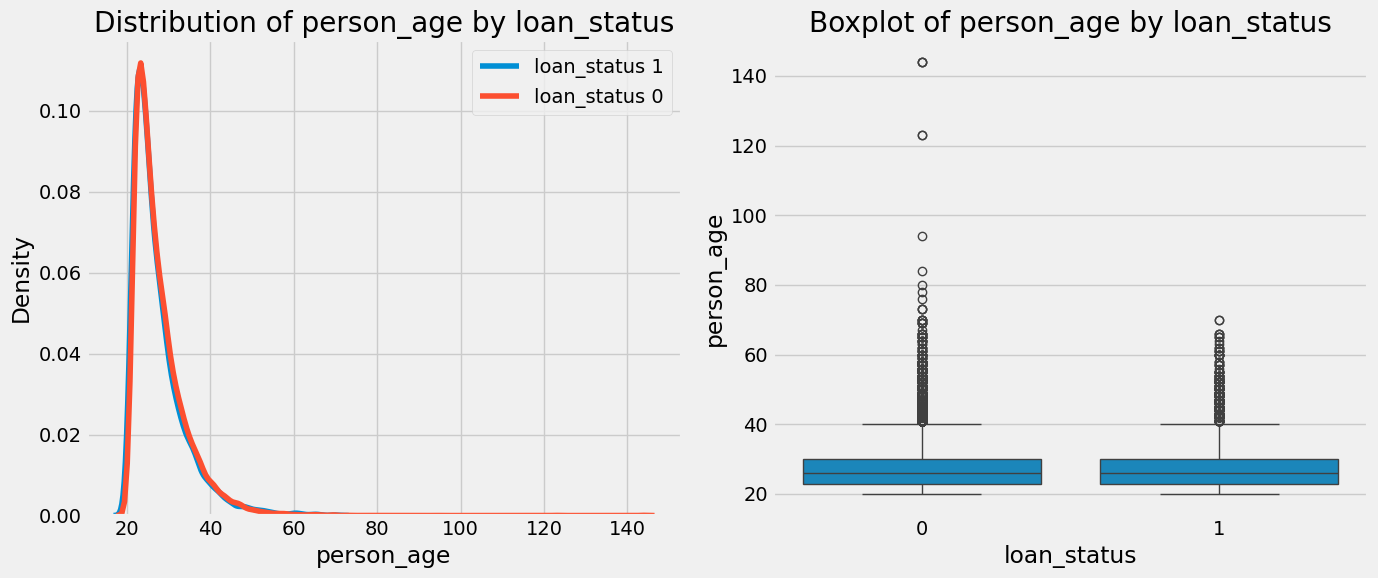

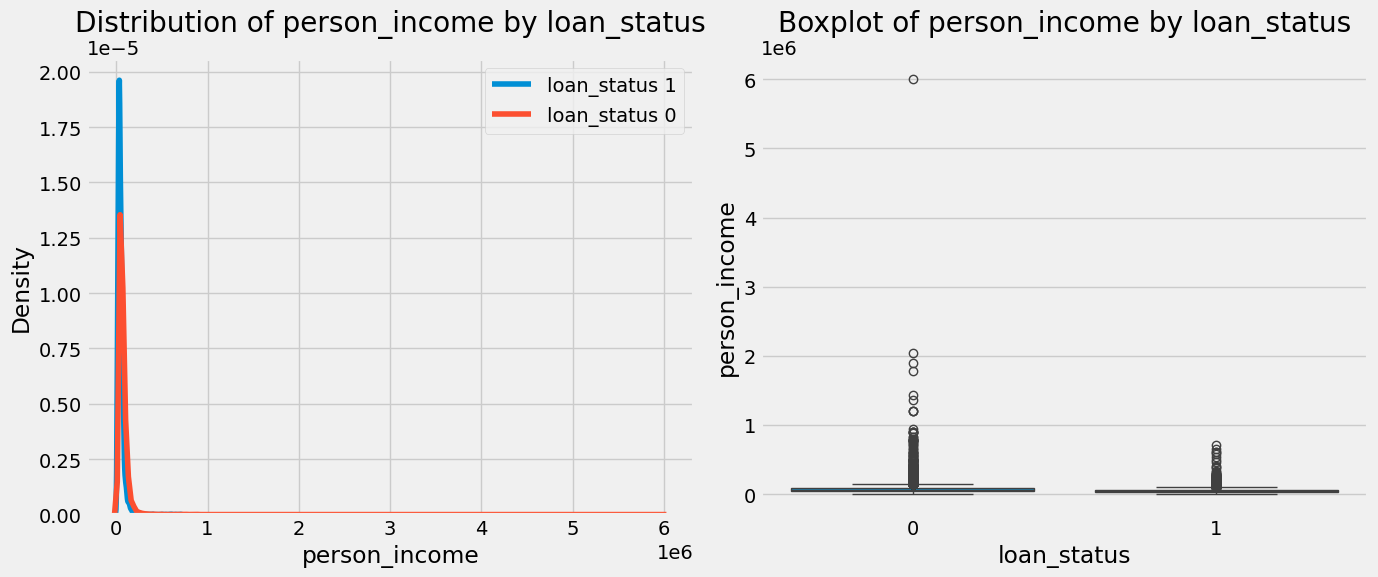

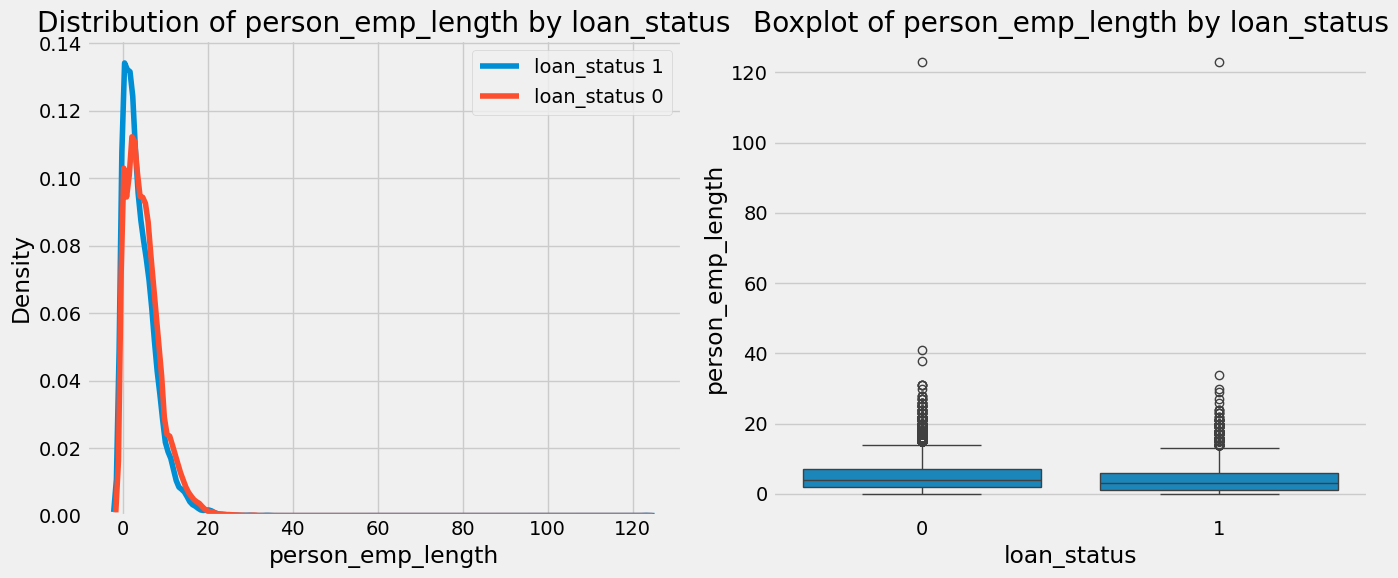

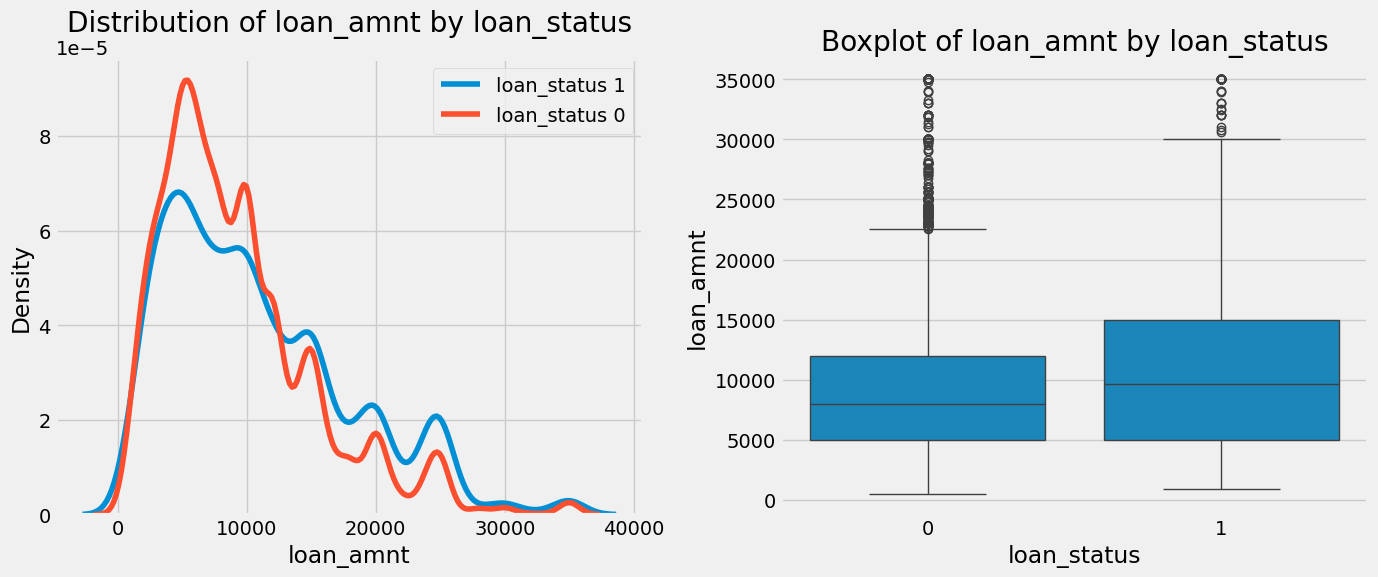

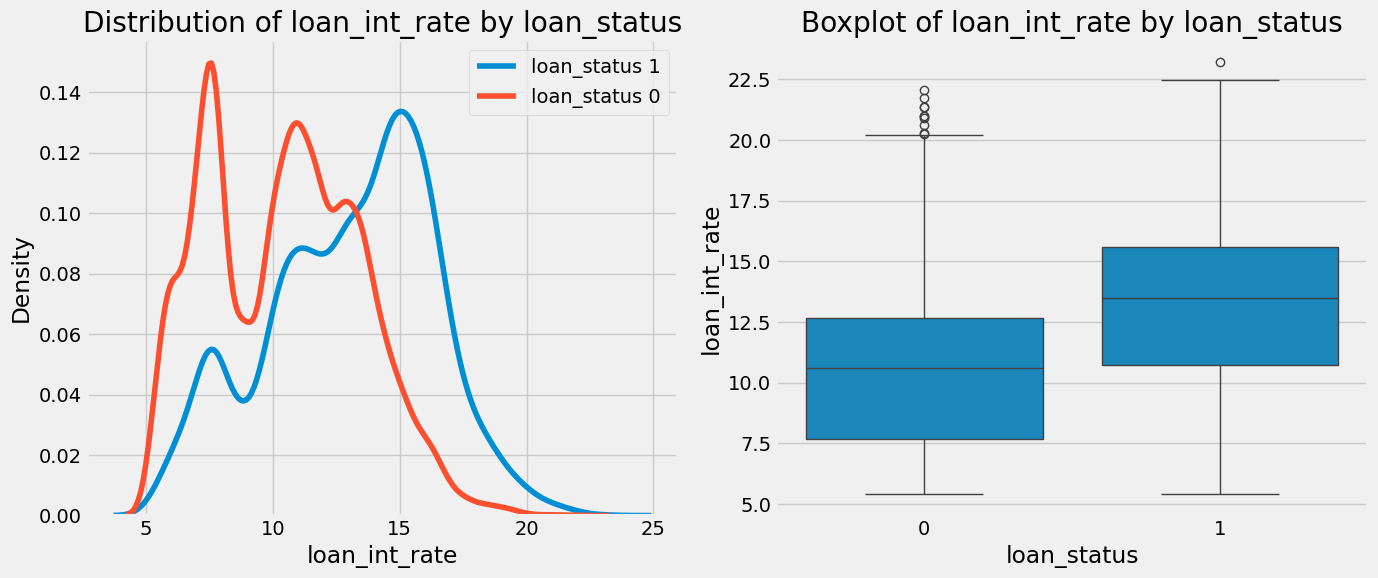

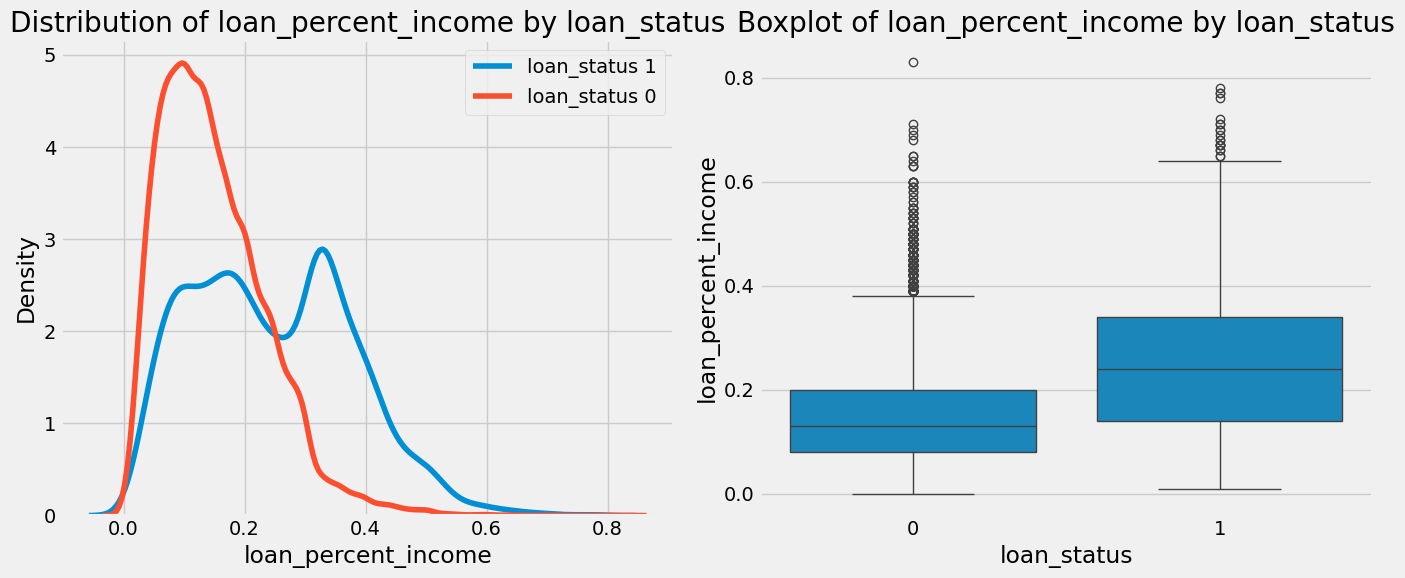

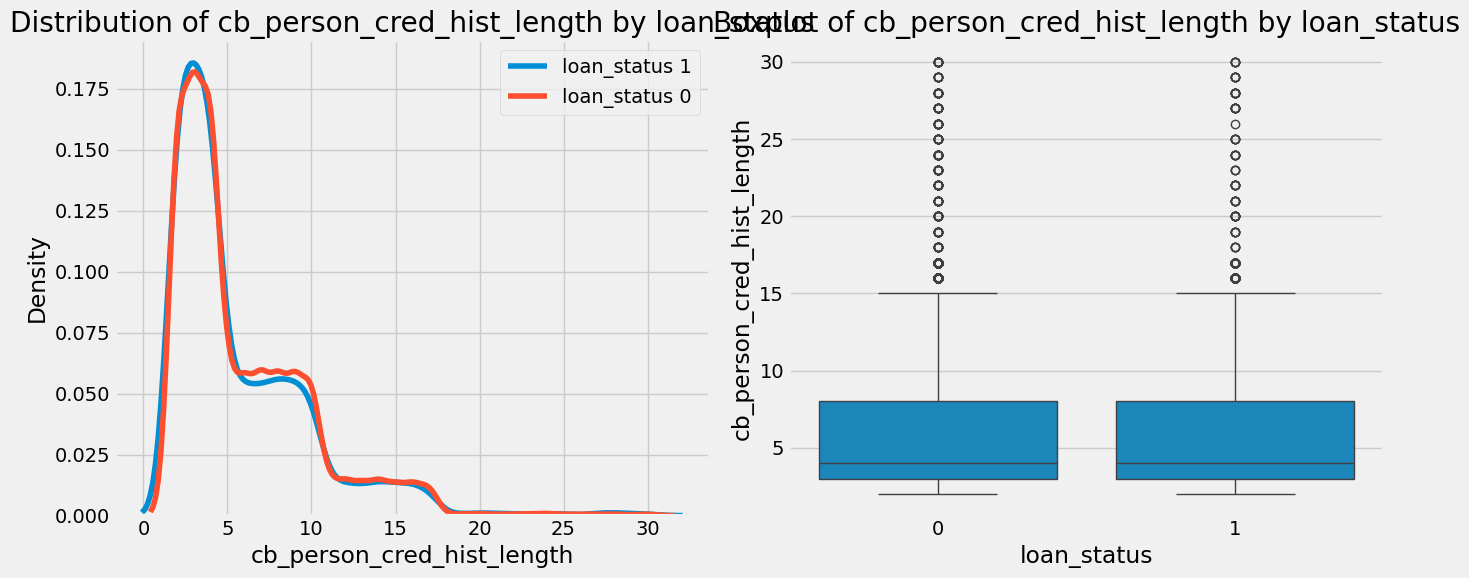

In [11]:
numerical_columns = df.select_dtypes("number").columns  # Get the numerical columns

for numerical_column in numerical_columns:
    if numerical_column != "loan_status":
        plot_dist_numerical_by_target(df, numerical_column, "loan_status")

2 features that shows higher chance loan status disapproval: `loan percent income` is high and `loan interest rate` are both high

### Categorical vs Target

In [12]:
def plot_count_categorical_by_target(df: pd.DataFrame, categorical_column: str, target_column: str) -> None:
    """
    Show count of values inside categorical column, grouped by a target column.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        categorical_column (str): The categorical column to be plotted.
        target_column (str): The target column for grouping.
    Returns
    ------------
        None
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure

    # Bar plot with hue
    sns.countplot(data=df, x=categorical_column, hue=target_column, ax=ax, edgecolor='black')
    ax.set_title(f"Count of {categorical_column} by target_column")
    ax.set_xlabel(categorical_column)
    ax.set_ylabel("Count")

    # Rotate x labels
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()


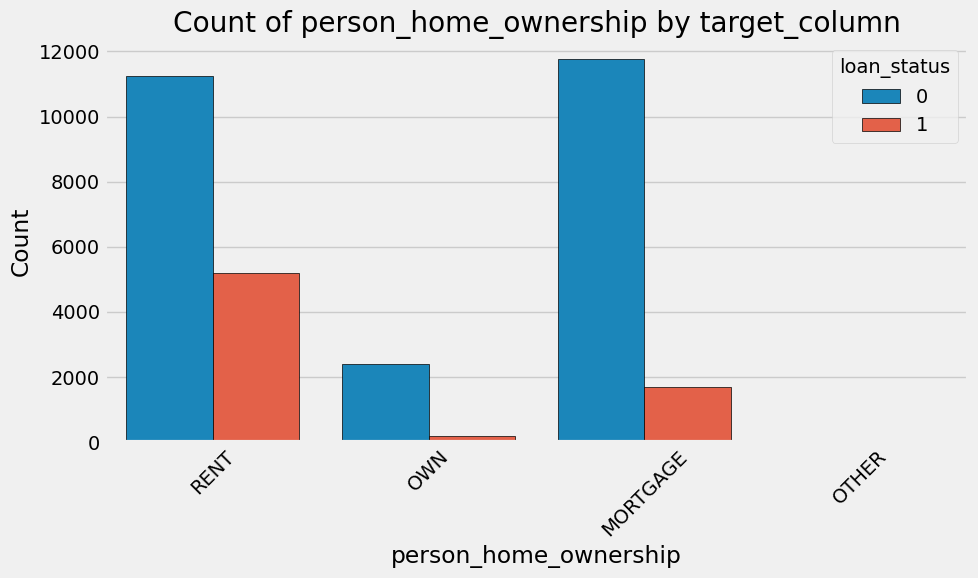

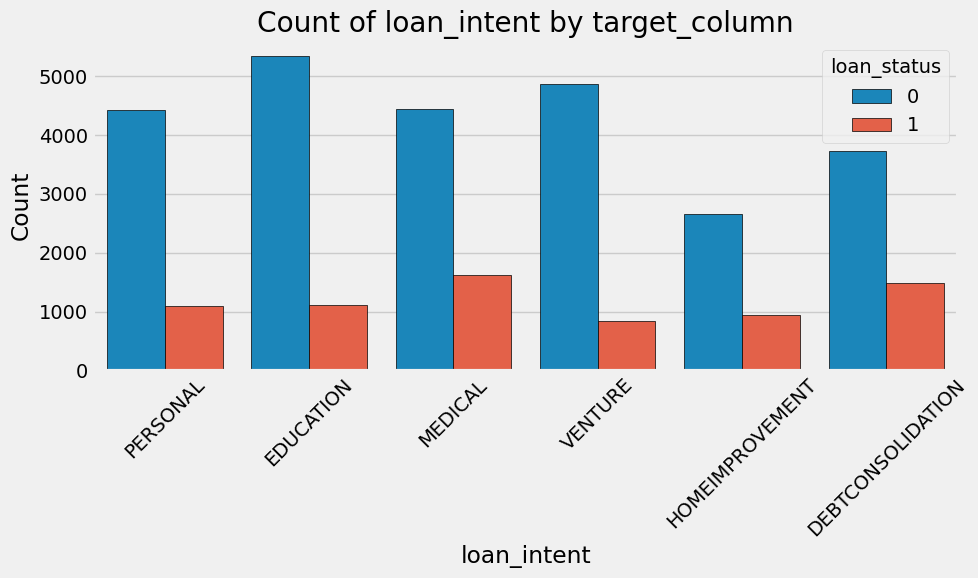

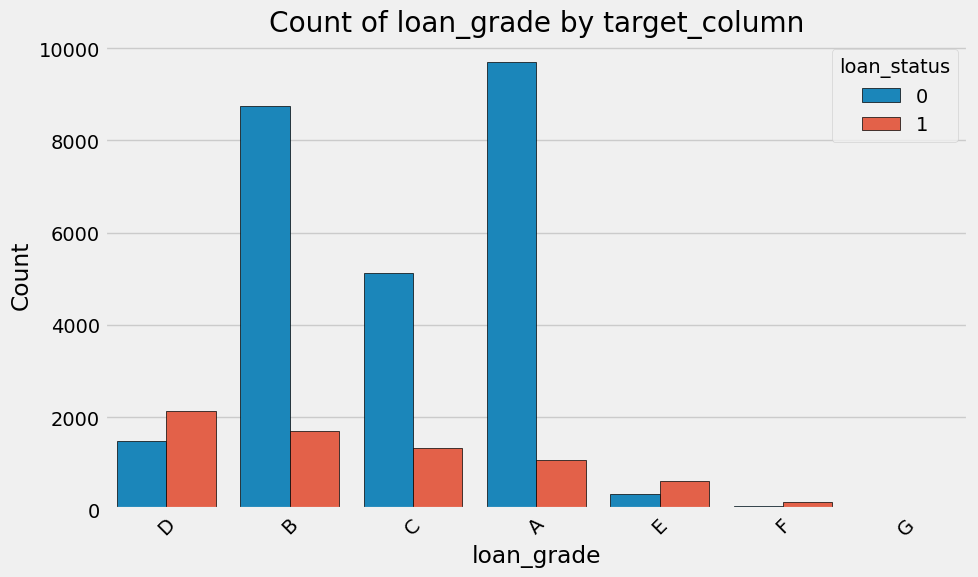

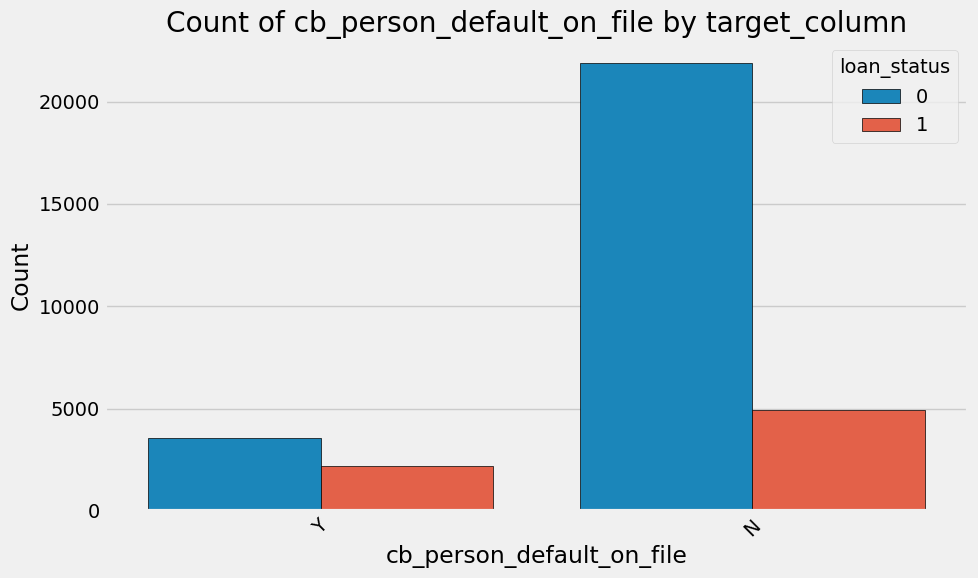

In [13]:
# Assuming df is your DataFrame and "loan_status" is the target variable
plt.style.use('fivethirtyeight')

categorical_columns = df.select_dtypes("object").columns
for categorical_column in categorical_columns:
    plot_count_categorical_by_target(df, categorical_column, "loan_status")

In [14]:
# Probability of default/ not default given values of `cb_person_default_on_file`
prob_result = df.groupby("cb_person_default_on_file")['loan_status'].value_counts(normalize=True).unstack(fill_value=0)

# Display the result
prob_result

loan_status,0,1
cb_person_default_on_file,,
N,0.816068,0.183932
Y,0.621932,0.378068


Those who has history of default in the past has 37% probability of default.

In [15]:
# Probability of default/ not default given values of `person_home_ownership`
prob_result = df.groupby('person_home_ownership')['loan_status'].value_counts().unstack(fill_value=0) / len(df)

# Display the result
prob_result

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.360762,0.051871
OTHER,0.002271,0.001013
OWN,0.073386,0.005924
RENT,0.345416,0.159357


2. Those who still **rent** has 16% probability of default.


In [16]:
# Probability of default/ not default given values of `loan_grade`
prob_result = df.groupby('loan_grade')['loan_status'].value_counts().unstack(fill_value=0) / len(df)

# Display the result
prob_result

loan_status,0,1
loan_grade,,
A,0.297842,0.032933
B,0.268561,0.052208
C,0.157116,0.041098
D,0.045579,0.065713
E,0.010528,0.019060
F,0.002179,0.005218
G,0.000031,0.001934


## Multicollinearity

In [17]:
def plot_heatmap(df: pd.DataFrame, figsize: Tuple[int, int]) -> None:
    """
    Show the visualization of coefficient correlation amongst features.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure

    # Calculate the coefficient correlation
    corr = df.select_dtypes(include='number').corr()

    # Plot the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

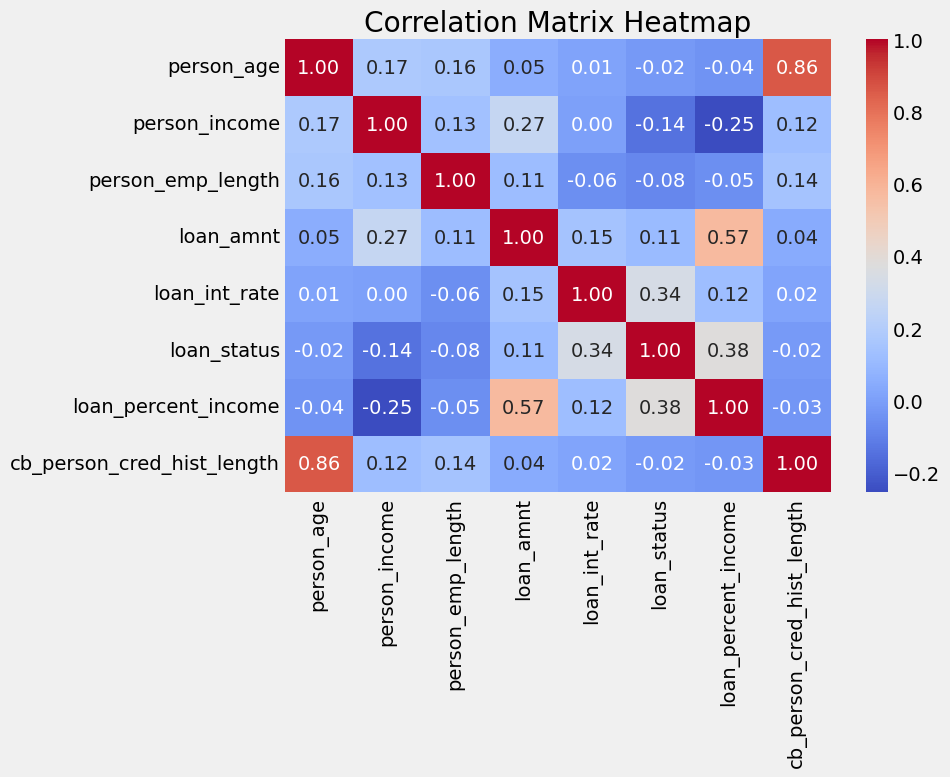

In [18]:
plot_heatmap(df, (10, 8))

In [19]:
def plot_scatter(df: pd.DataFrame, x: str, y: str, figsize: Tuple[int, int]) -> None:
    """
    Show scatter plot between two numerical columns.
    
    Parameters
    ------------
        df (pd.DataFrame): The dataframe containing the data.
        x (str): numerical column for the x-axis.
        y (str): numerical column for the y-axis.
        figsize (Tuple[int, int]): size of the plot.
    Returns
    ------------
        None
    """
    _, ax = plt.subplots(figsize=figsize)  # Create a figure
    
    # Create scatterplot with customized aesthetics
    sns.scatterplot(x=x, y=y, data=df, color='skyblue', ax=ax)

    # Add trend line
    sns.regplot(x=x, y=y, data=df, scatter=False, color='orange', ci=None, ax=ax)

    # Add labels and title
    ax.set_title(f"{x} vs {y}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    # Show plot
    plt.show()

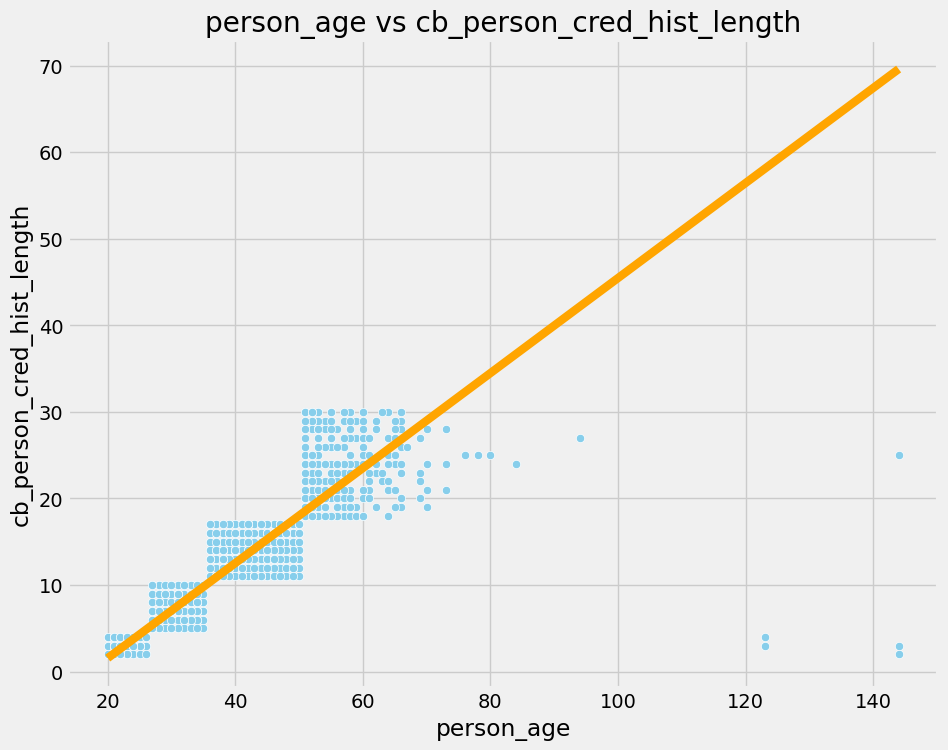

In [20]:
plot_scatter(df, "person_age", "cb_person_cred_hist_length", (10, 8))

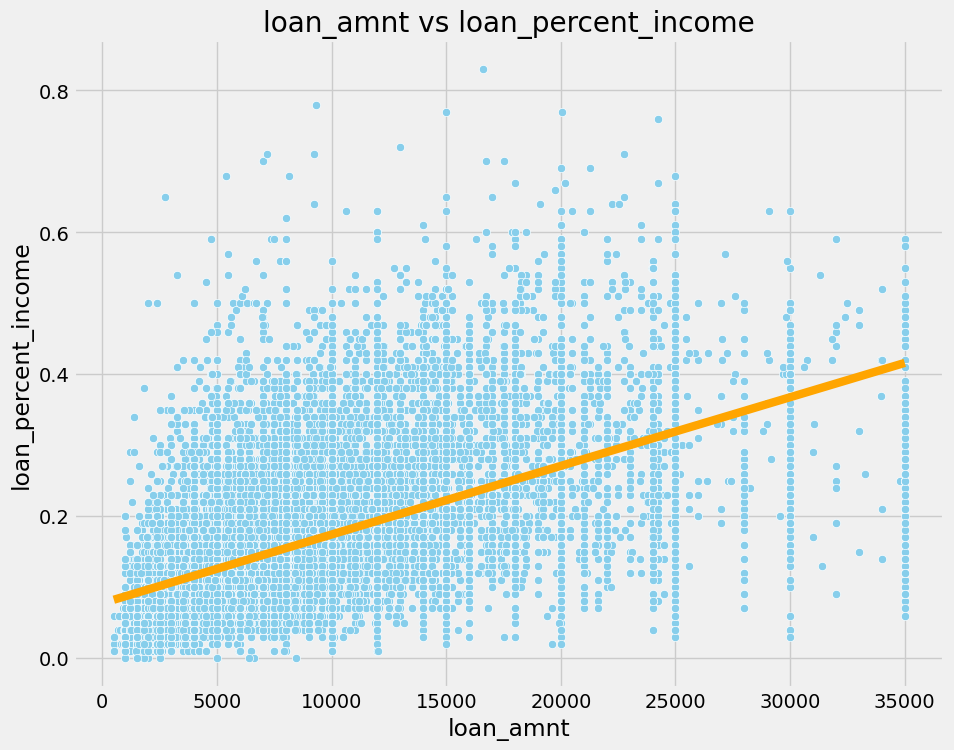

In [21]:
plot_scatter(df, "loan_amnt", "loan_percent_income", (10, 8))

# Data Preparation
For this data preparation involves:
1. Calculating the **Weight of Evidence (WOE)** and **Information Value (IV)**
2. Filter features based on the **IV**
3. Map feature values into WOE values. 

Class:
1. WOETransformer
    - Calculate WOE
    - Create mapping
2. IVTransformer
    - Transformer WOE to IV
    - Interpret the IV value
    - Filter IV
3. DataPreprocessor 
    - Split Data
    - Create binning
4. Visualizer:
    - plot data (show/ save)
5. Model
    - Train
    - Predict
    - Evaluate
6. ScoreTransformer:
    - Calculate score using WOE
    - Transform to WOE

In [9]:
# Used for storing metadata about training process
metadata = {}

## Data Splitting

In [14]:
# Imports
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from scipy import stats
from typing import Tuple
from typing import Union
from sklearn.model_selection import train_test_split

class DataPreprocessing:
    @staticmethod
    def split_data(df: pd.DataFrame, target_variable: str, test_size: float, random_state: int) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """
        Split data into train and test data evenly based on their target_variable values.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            target_variable (str): target_variable column.
            test_size (float): Proportion of dataset pick testing.
            random_state (int): Random state for splitting data.
        Returns:
            Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: Train and test set.
        """
        X, y = df.drop(columns=[target_variable]), df[target_variable]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, shuffle=True, random_state=42)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)
        return (X_train, X_test, y_train, y_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Prepare arguments
df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
target_variable = 'loan_status'
test_size = 0.2
random_state = 42

# Create metadata for arguments
data_splitting_meta = {
    'target_variable': target_variable,
    'test_size': test_size,
    'random_state': random_state,
}
metadata['data_preprocessing'] = {
    'data_splitting': data_splitting_meta
} 

# split data betweem train and text
X_train, X_test, y_train, y_test = DataPreprocessing.split_data(
    df=df, 
    target_variable=target_variable,
    test_size=test_size,
    random_state=random_state
)

print(f'Train features: {X_train.shape}, Train Target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test Target: {y_test.shape}')
print(metadata)

Train features: (26064, 11), Train Target: (26064,)
Test features: (6517, 11), Test Target: (6517,)
{'data_preprocessing': {'data_splitting': {'target_variable': 'loan_status', 'test_size': 0.2, 'random_state': 42}}}


## Weight of Evidence (WOE) and Information Value (IV) Analysis

In [36]:
from optbinning import OptimalBinning

# Generate dictionary contain OptimalBinning objects
target_variable = 'loan_status'
optb_objs = {}
for column in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[column]):
        optb = OptimalBinning(name=column, dtype='numerical', solver='cp')    
    elif X_train[column].dtype == "object":
        optb = OptimalBinning(name=column, dtype='categorical', solver='cp')
    
    optb.fit(X_train[column], y_train)
    optb_objs[column] = optb

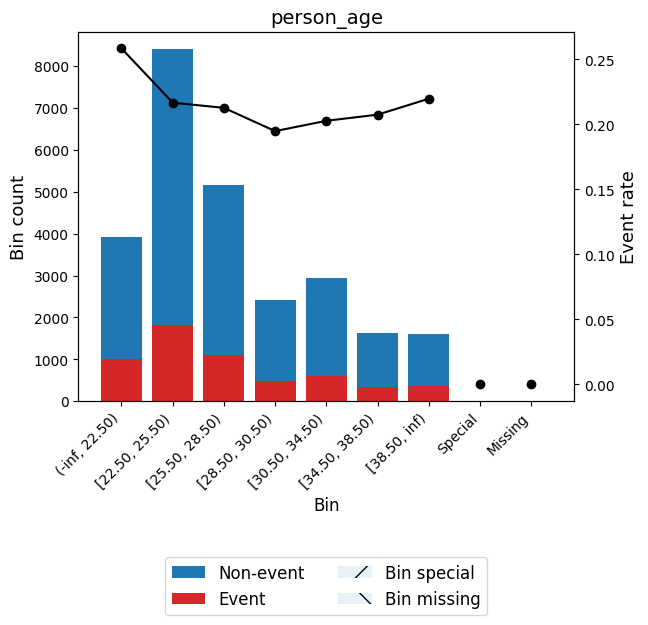

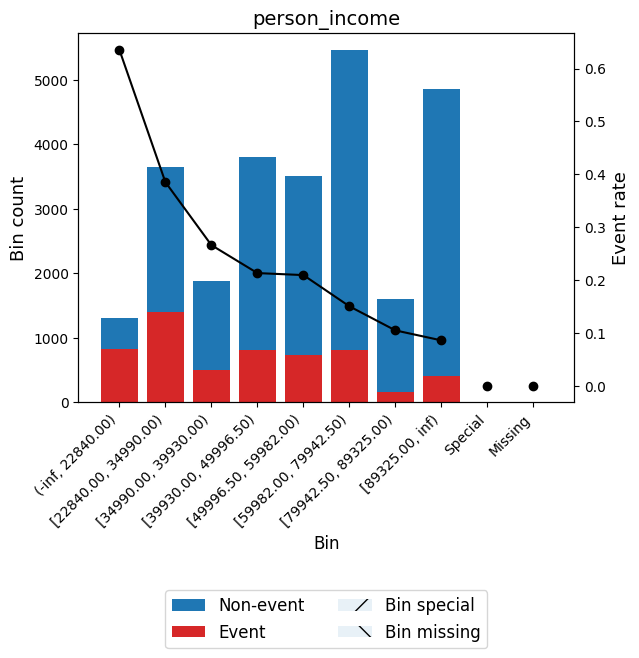

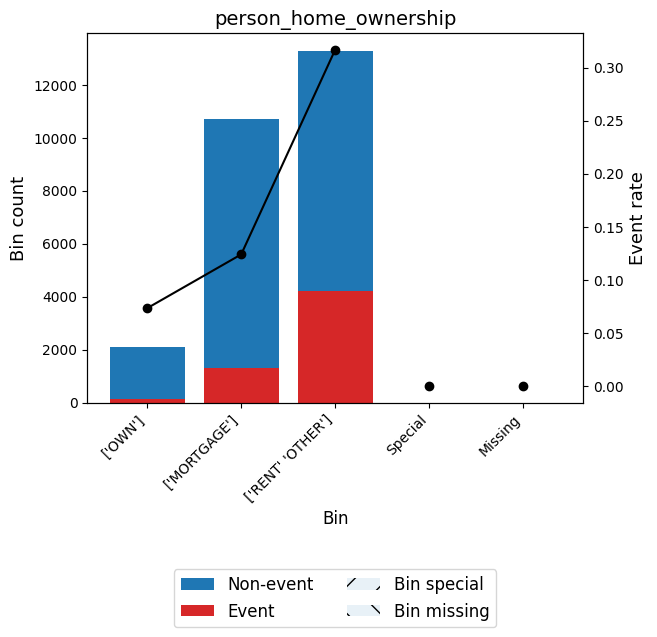

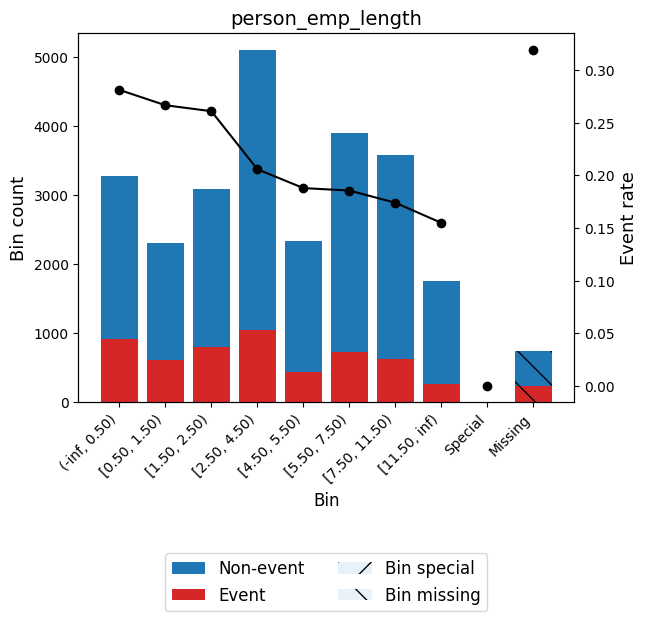

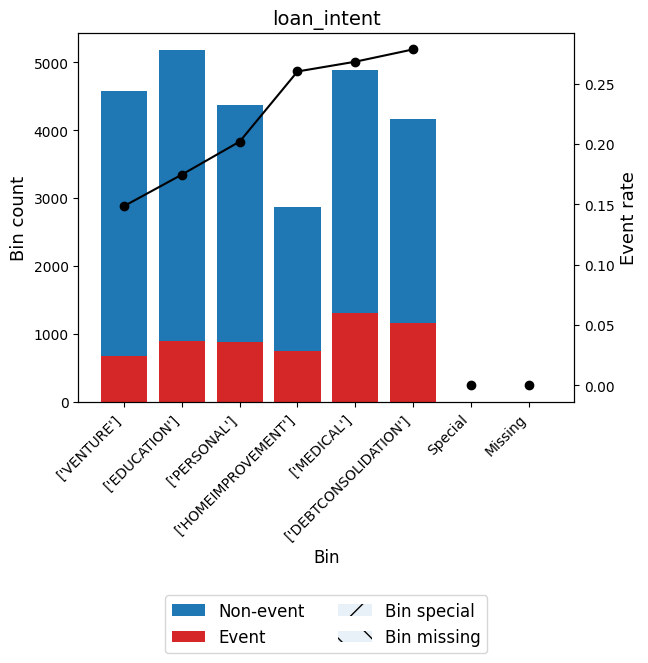

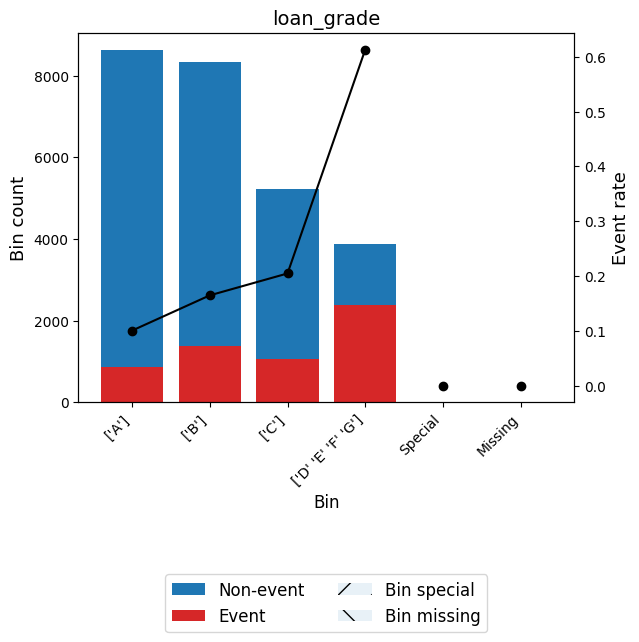

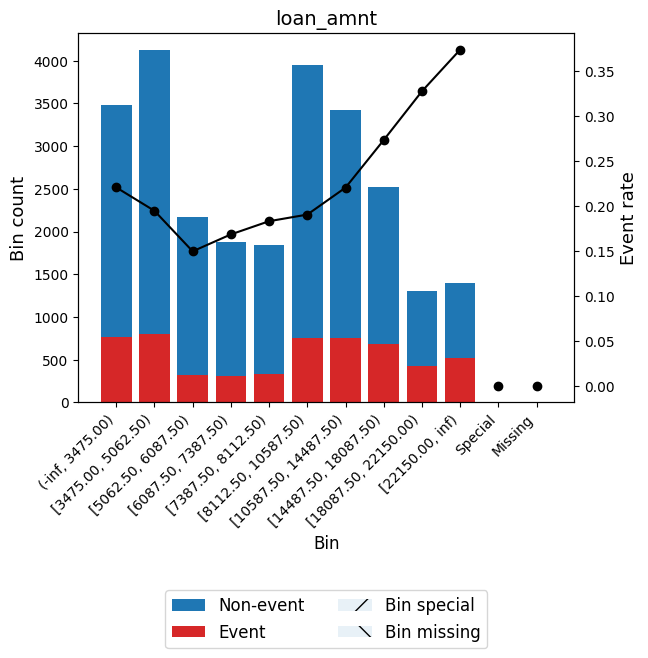

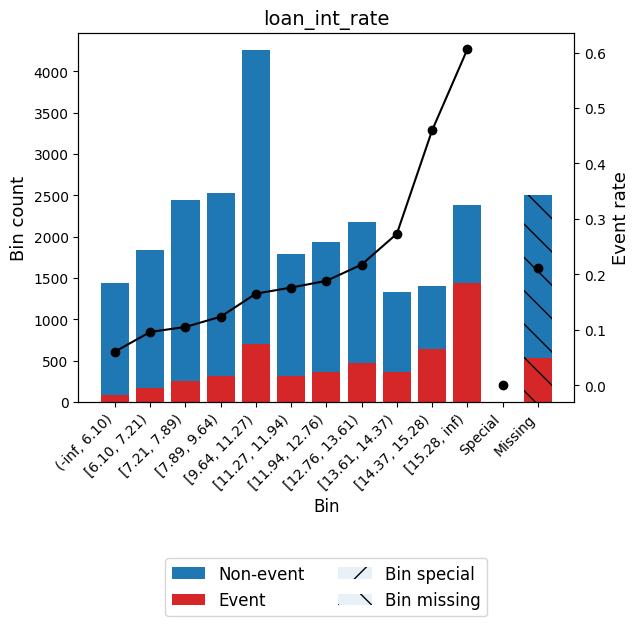

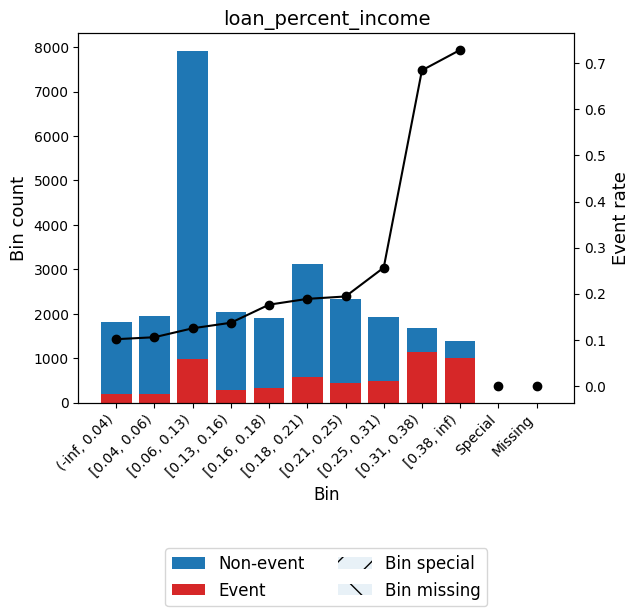

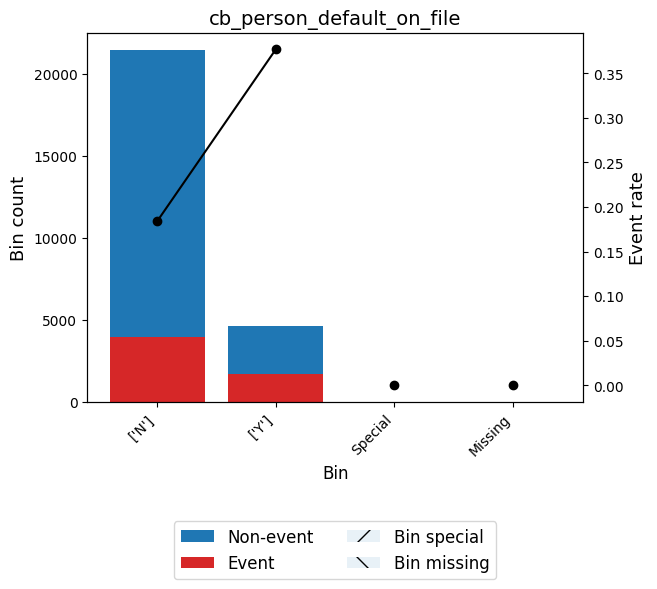

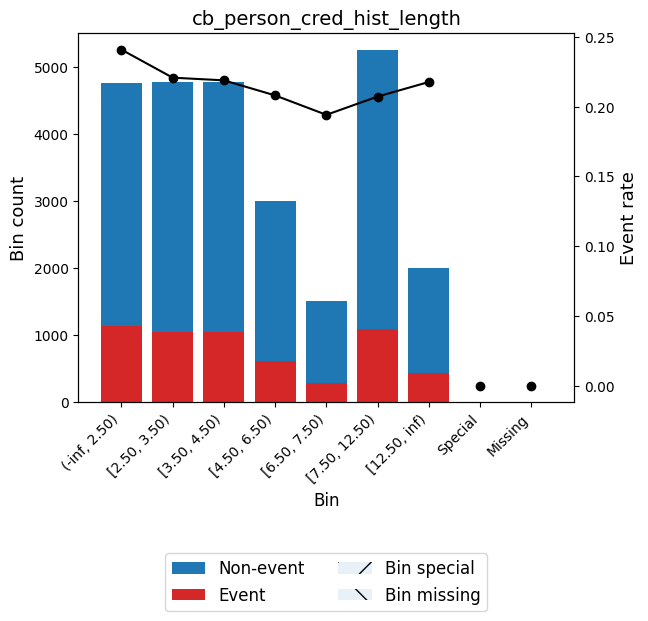

In [37]:
for _, optb in optb_objs.items():
    binning_table = optb.binning_table
    binning_table.build()
    binning_table.plot(metric="event_rate", show_bin_labels=True)

1. Those who are still producing low income has a high probability of default.
2. Those who are still new in the job has a high probability of default.
3. High interest rate (`loan_int_rate`) has a high probability of default.
4. Hihg proportion of loan with respect to income (`loan_percent_income`) has a high probability of default. 

### 2. Calculate WoE and IV
WOE and IV is already automatically calculated using the build() method

In [38]:
characteristics = []
ivs = []
for column, optb in optb_objs.items():
    binning_table = optb.binning_table
    characteristics.append(column)
    ivs.append(binning_table.build().loc["Totals", "IV"])

IV_df = pd.DataFrame({
    "Characteristic": characteristics,
    "IV": ivs
})

In [39]:
# 3. Filter those with low value of IV
def interpret_iv(value):
    if value < 0.02:
        return "Not Predictive"
    elif 0.02 <= value and value < 0.1:
        return "Weak Predictive"
    elif 0.1 <= value and value < 0.3:
        return "Medium Predictive"
    elif 0.3 <= value and value < 0.5:
        return "Strong Predictive"
    else:
        return "Very Strong Predictive"

IV_df["Interpretation"] = IV_df["IV"].apply(lambda x: interpret_iv(x))
IV_df = IV_df.sort_values(by="IV", ascending=False)
IV_df

,Characteristic,IV,Interpretation
8,loan_percent_income,0.952405,Very Strong Predictive
5,loan_grade,0.845847,Very Strong Predictive
7,loan_int_rate,0.682771,Very Strong Predictive
1,person_income,0.573963,Very Strong Predictive
2,person_home_ownership,0.389704,Strong Predictive
9,cb_person_default_on_file,0.162480,Medium Predictive
6,loan_amnt,0.097241,Weak Predictive
4,loan_intent,0.088686,Weak Predictive
3,person_emp_length,0.068640,Weak Predictive
0,person_age,0.011128,Not Predictive


Exclude Characteristic with is interpret as `Not Predictive`

In [8]:
for _, optb in optb_objs.items():
    binning_table = optb.binning_table
    binning_table.build()
    binning_table.plot(metric="woe", show_bin_labels=True)

NameError: name 'optb_objs' is not defined

# !! Proofing **BinningProcess** is just a wrapper for multiple **OptimalBinning**(s)

In [42]:
# Generate dictionary contain OptimalBinning objects for all variables
from optbinning import OptimalBinning

target_variable = 'loan_status'
X_train_opt_bin, y_train_opt_bin = X_train.copy(), y_train.copy()
optb_objs = {}
for column in X_train_opt_bin.columns:
    if pd.api.types.is_numeric_dtype(X_train_opt_bin[column]):
        optb = OptimalBinning(name=column, dtype='numerical', solver='cp')    
    elif X_train_opt_bin[column].dtype == "object":
        optb = OptimalBinning(name=column, dtype='categorical', solver='cp')
    
    optb.fit(X_train_opt_bin[column], y_train_opt_bin)
    optb_objs[column] = optb

# Transform training data into WoE
X_train_opt_bin, y_train_opt_bin = train.drop(columns=['loan_status']), train['loan_status']
for column, optb in optb_objs.items():
    X_train_opt_bin[column] = optb.transform(X_train_opt_bin[column], metric='woe')

In [43]:
# Data Preparation
from optbinning import BinningProcess
X_train_bin_proc, y_train_bin_proc = X_train.copy(), y_train.copy()
categorical_variables = X_train_bin_proc.select_dtypes("object").columns.values

binning_process = BinningProcess(
    X_train_bin_proc.columns.values, 
    categorical_variables=categorical_variables, 
)
binning_process.fit(X_train_bin_proc, y_train_bin_proc)

# Transform training data to WoE
X_train_bin_proc = binning_process.transform(X_train_bin_proc, metric="woe")

In [44]:
# Compare both dataframes
X_train_opt_bin.equals(X_train_bin_proc)

True

WoE calculation between ***BinningProcess*** and ***OptimalBinning*** are the same. Why compare it? Because I havent found a way to plot **Weight of Evidence** and **Event Rate** individually with the target variable `loan_status`.

# Modelling

In [34]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

class EvaluationMetrics:

    @staticmethod
    def roc_auc(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate ROC AUC (Area Under the Receiver Operating Characteristic Curve).
        
        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: ROC AUC score.
        """
        return roc_auc_score(y_true, y_pred_proba)

    @staticmethod
    def pr_auc(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate PR AUC (Area Under the Precision Recall Curve).
        
        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: PR AUC score.
        """
        return average_precision_score(y_true, y_pred_proba)

    @staticmethod
    def gini(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate Gini coefficient.

        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: Gini coefficient.
        """
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return 2 * roc_auc - 1

    @staticmethod
    def ks(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate Kolmogorov-Smirnov (KS) statistic.

        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: KS statistic.
        """
        y_pred_proba_not_default = y_pred_proba[y_true == 0]
        y_pred_proba_default = y_pred_proba[y_true == 1]
        ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)
        return ks_stat

In [31]:
def plot_pred_proba_distribution(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the predicted probability distributions for the default and non-default classes.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """

    # Create a figure and axis object
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))

    # Plot histograms for the predicted probabilities
    sns.histplot(y_pred_proba[y_true == 0], label="Not Default", kde=True, color='blue', alpha=0.6, bins=30)
    sns.histplot(y_pred_proba[y_true == 1], label="Default", kde=True, color='red', alpha=0.6, bins=30)

    # Add title and axis labels
    plt.title('Predicted Probability Distributions for Default and Not Default', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add legend
    plt.legend(title='Label', fontsize=12, title_fontsize='13')

    # Show grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_roc_auc_curve(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the ROC curve and calculate the AUC.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line

    # Title and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

    # Add legend
    plt.legend(loc="lower right", fontsize=12)

    # Show grid for better readability
    plt.grid(axis='both', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_precision_recall_curve(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the Precision-Recall curve and calculate the Average Precision (AP).
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Compute Precision-Recall curve and average precision score
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)

    # Plotting the Precision-Recall curve
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {average_precision:.2f})')

    # Title and labels
    plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)

    # Add legend
    plt.legend(loc="lower left", fontsize=12)

    # Show grid for better readability
    plt.grid(axis='both', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def plot_ks(y_true: np.array, y_pred_proba: np.array) -> None:
    """
    Plot the Kolmogorov-Smirnov (KS) statistic.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
    Return:
        None
    """
    # Generate two sample distributions
    y_pred_proba_not_default = y_pred_proba[y_true == 0]
    y_pred_proba_default = y_pred_proba[y_true == 1]

    # Calculate the KS statistic
    ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)

    # Plot the CDFs
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred_proba_not_default, bins=50, density=True, histtype='step', cumulative=True, label='Not Default', linewidth=2)
    plt.hist(y_pred_proba_default, bins=50, density=True, histtype='step', cumulative=True, label='Default', linewidth=2)
    plt.axvline(ks_stat, linestyle="--", linewidth=2, color="black")
    plt.title('KS Plot')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend(title=f'KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}')
    plt.show()


def plot_calibration_curve(y_true: np.array, y_pred_proba: np.array, model_name: str, n_bins=10) -> None:
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)
    
    # Plot calibration curve
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:

# Prepare arguments
data_path = '../data/raw/credit_risk_dataset.csv'
target_variable = 'loan_status'
test_size = 0.2
random_state = 42
feature_selection_min_iv = 0.02
feature_selection_max_iv = 1
scorecard_scaling_method ='min_max'
scorecard_scaling_method_min = 300
scorecard_scaling_method_max = 850
scorecard_intercept_based = True

# Create metadata for arguments
data_ingestion_meta = {
    'data_path': data_path
}
data_preprocessing_meta = {
    'data_splitting': {
        'target_variable': target_variable,
        'test_size': test_size,
        'random_state': random_state,
    },
    'data_binning': {
        'categorical_variables': ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'],
        'selection_criteria': {
            'iv': {
                'min': feature_selection_min_iv,
                'max': feature_selection_max_iv
            }
        }
    }
}
modelling_meta = {
    'logistic_regression':{
        'random_state': random_state
    },
    'scorecard': {
        'scaling_method': scorecard_scaling_method,
        'scaling_method_params': {
            'min': scorecard_scaling_method_min, 
            'max': scorecard_scaling_method_max
        },
        'intercept_based': scorecard_intercept_based
    }
}

# Insert into metadata
metadata = {}
metadata['data_ingestion'] = data_ingestion_meta
metadata['data_preprocessing'] = data_preprocessing_meta
metadata['modelling'] = modelling_meta

# Data ingestion
df = DataIngestion.ingest_data(
    paths=[
        metadata['data_ingestion']['data_path']
    ],
    strategy=PandasDataIngestionStrategy()
)

# Data Preprocessing
X_train, X_test, y_train, y_test = DataPreprocessing.split_data(
    df=df, 
    target_variable=metadata['data_preprocessing']['data_splitting']['target_variable'],
    test_size=metadata['data_preprocessing']['data_splitting']['test_size'],
    random_state=metadata['data_preprocessing']['data_splitting']['random_state']
)

# Instantiate BinningProcess
binning_process = BinningProcess(
    X_train.columns.values, 
    categorical_variables=metadata['data_preprocessing']['data_binning']['categorical_variables'], 
    selection_criteria=metadata['data_preprocessing']['data_binning']['selection_criteria']
)

# Instantiate Scorecard Model
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=LogisticRegression(
        random_state=metadata['modelling']['logistic_regression']['random_state']
    ), 
    scaling_method=metadata['modelling']['scorecard']['scaling_method'],
    scaling_method_params=metadata['modelling']['scorecard']['scaling_method_params'],  # FICO score range
    intercept_based=metadata['modelling']['scorecard']['intercept_based']
)

# Train
scorecard.fit(X_train, y_train)

2024-05-28 15:17:58,160 - root - INFO - Load data using PandasDataIngestionStrategy
2024-05-28 15:17:58,161 - __main__ - INFO - Loading ..\data\raw\credit_risk_dataset.csv
2024-05-28 15:17:58,201 - __main__ - INFO - Loading data finished. Duration: 0.039042499993229285 s


Scorecard(binning_process=BinningProcess(categorical_variables=['person_home_ownership',
                                                                'loan_intent',
                                                                'loan_grade',
                                                                'cb_person_default_on_file'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02}},
                                         variable_names=array(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype=object)),
          estimator=LogisticRegression(random_state=42), intercept_based=True,
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [28]:
intercept = scorecard.estimator_.intercept_
variables = scorecard.binning_process_.get_support(names=True)
coefs = scorecard.estimator_.coef_.reshape(-1)

print("Intercept(s): ", intercept)
print("Coef:")
for feature, coef in zip(variables, coefs):
    print(f"{feature} = {coef:.5f}")

Intercept(s):  [-1.37918438]
Coef:
person_income = -0.87680
person_home_ownership = -0.93203
person_emp_length = -0.28765
loan_intent = -1.48536
loan_grade = -1.17238
loan_amnt = -0.54707
loan_int_rate = -0.10217
loan_percent_income = -0.98717
cb_person_default_on_file = 0.03208


AUC: 0.8868805188687241
AUCPR: 0.7700380359777539
Gini: 0.7737610377374482
KS: 0.6405185228171035


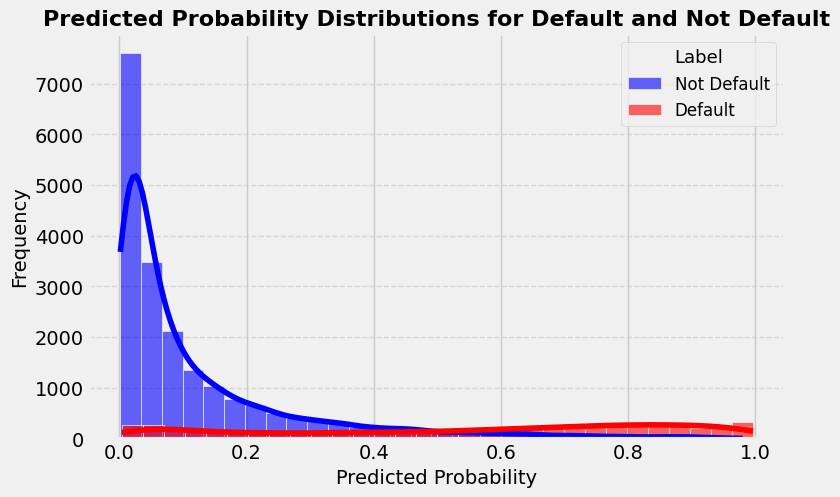

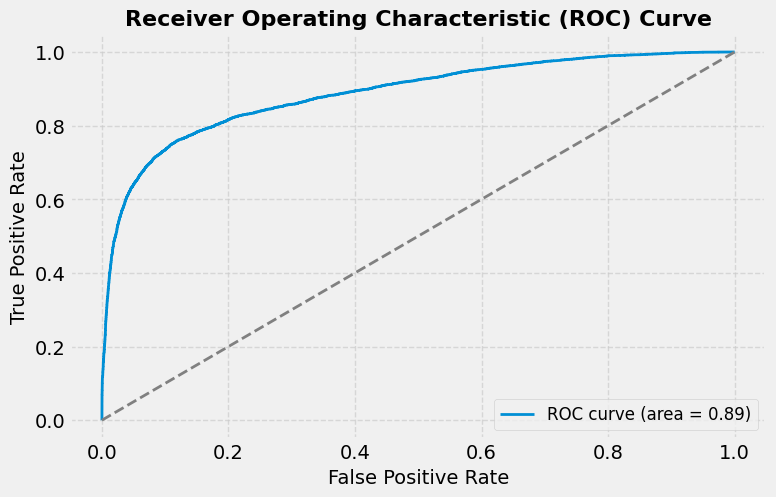

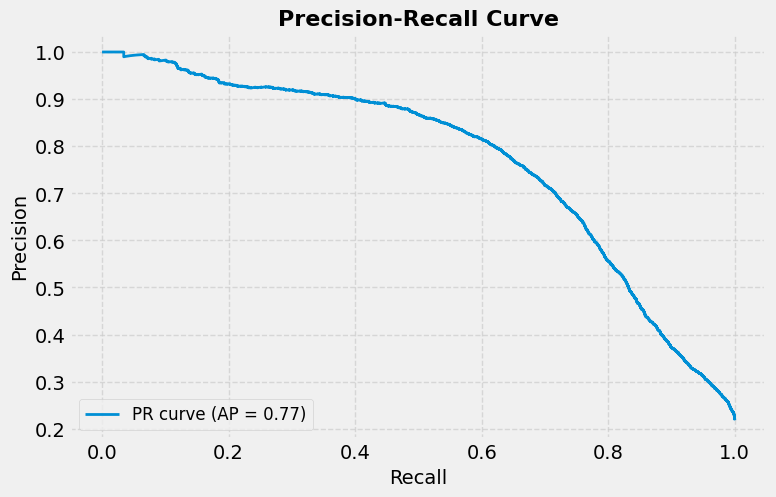

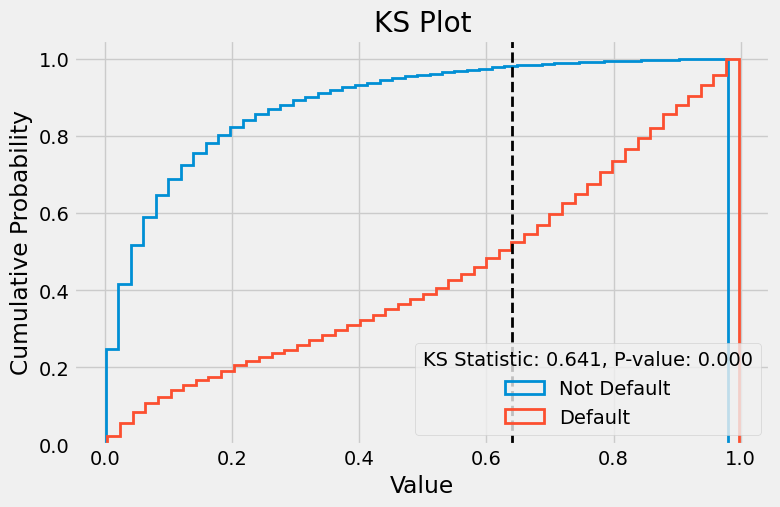

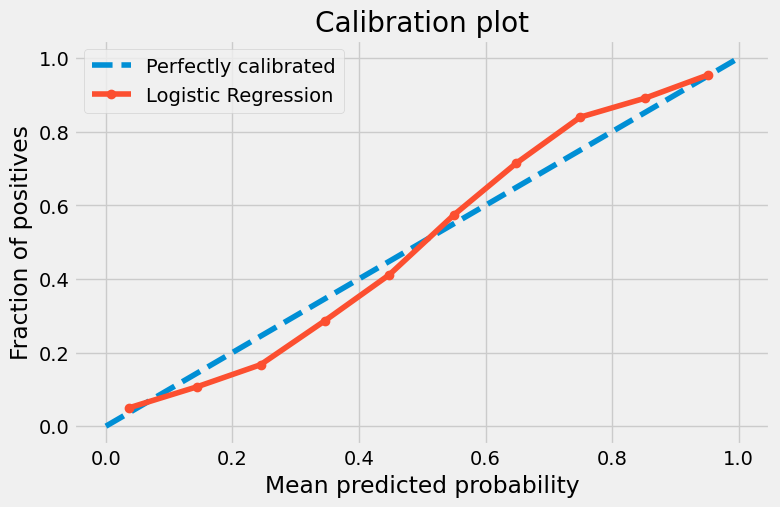

In [36]:
y_pred_proba = scorecard.predict_proba(X_train)[:, -1]
roc_auc = EvaluationMetrics.roc_auc(y_train, y_pred_proba)
roc_pr_auc = EvaluationMetrics.pr_auc(y_train, y_pred_proba)
gini = EvaluationMetrics.gini(y_train, y_pred_proba)
ks = EvaluationMetrics.ks(y_train, y_pred_proba)

print(f"AUC: {roc_auc}")
print(f"AUCPR: {roc_pr_auc}")
print(f"Gini: {gini}")
print(f"KS: {ks}")

plot_pred_proba_distribution(y_train, y_pred_proba)
plot_roc_auc_curve(y_train, y_pred_proba)
plot_precision_recall_curve(y_train, y_pred_proba)
plot_ks(y_train, y_pred_proba)
plot_calibration_curve(y_train, y_pred_proba, "Logistic Regression")

AUC: 0.8823342429148568
AUCPR: 0.7585110965398347
Gini: 0.7646684858297137
KS: 0.6397834947529982


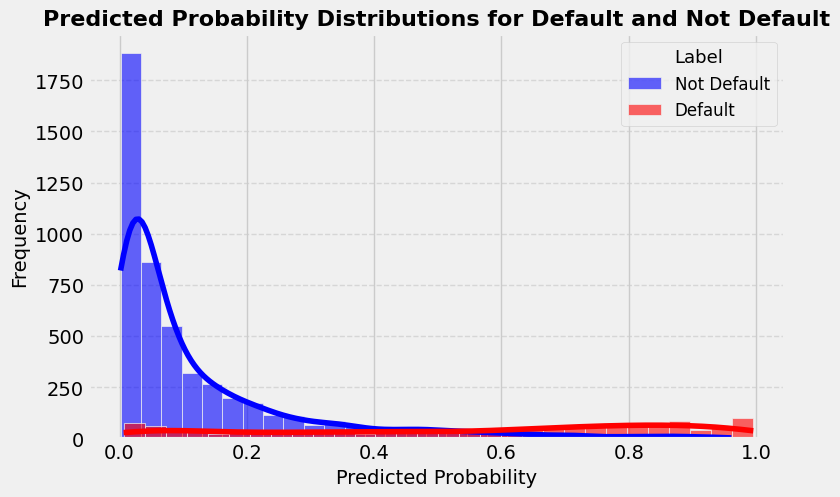

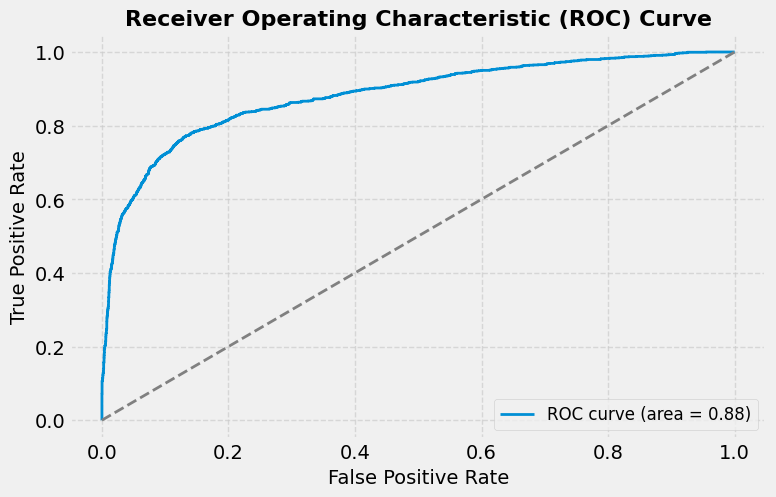

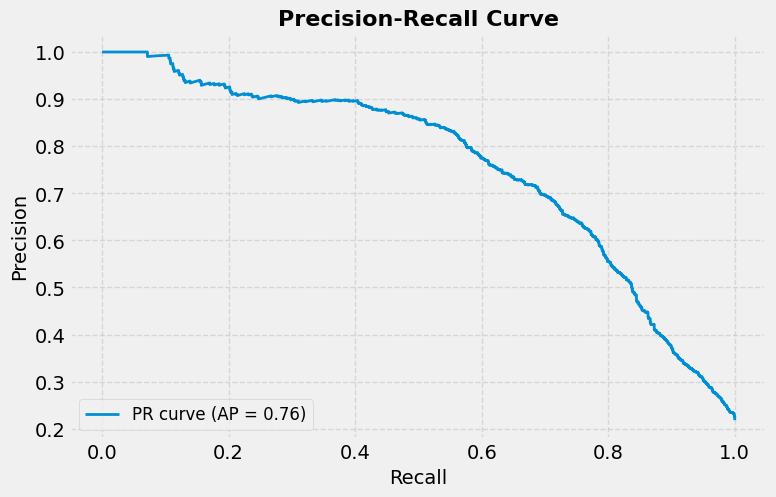

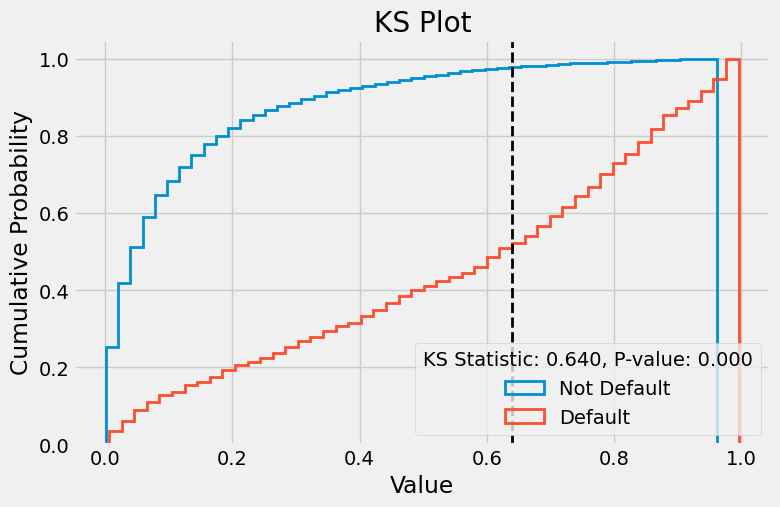

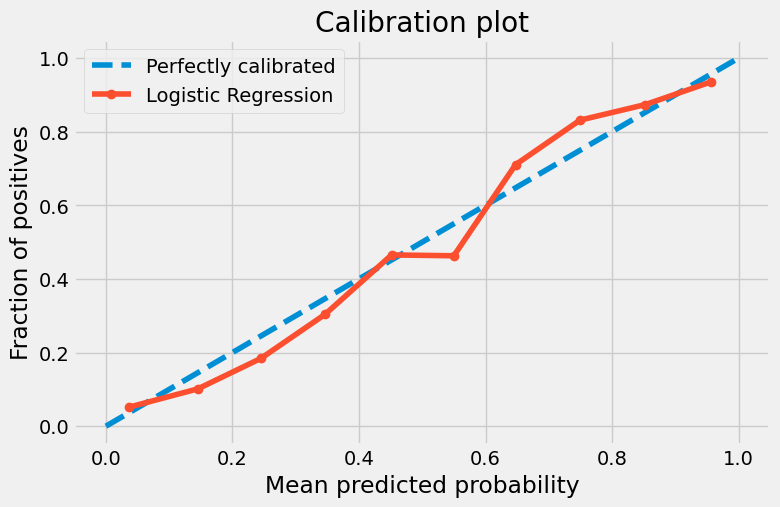

In [37]:
y_pred_proba = scorecard.predict_proba(X_test)[:, -1]
roc_auc = EvaluationMetrics.roc_auc(y_test, y_pred_proba)
roc_pr_auc = EvaluationMetrics.pr_auc(y_test, y_pred_proba)
gini = EvaluationMetrics.gini(y_test, y_pred_proba)
ks = EvaluationMetrics.ks(y_test, y_pred_proba)

print(f"AUC: {roc_auc}")
print(f"AUCPR: {roc_pr_auc}")
print(f"Gini: {gini}")
print(f"KS: {ks}")

plot_pred_proba_distribution(y_test, y_pred_proba)
plot_roc_auc_curve(y_test, y_pred_proba)
plot_precision_recall_curve(y_test, y_pred_proba)
plot_ks(y_test, y_pred_proba)
plot_calibration_curve(y_test, y_pred_proba, "Logistic Regression")

# Create Credit Scorecard

In [38]:
# Show scorecard table
scorecard_table = scorecard.table(style="summary").reset_index(drop=True)
scorecard_table

,Variable,Bin,Points
0,person_income,"(-inf, 22840.00)",0.000000
1,person_income,"[22840.00, 34990.00)",38.354804
2,person_income,"[34990.00, 39930.00)",58.862503
3,person_income,"[39930.00, 49996.50)",69.779842
4,person_income,"[49996.50, 59982.00)",70.635553
...,...,...,...
75,loan_percent_income,Missing,95.520163
76,cb_person_default_on_file,[N],0.000000
77,cb_person_default_on_file,[Y],1.351975
78,cb_person_default_on_file,Special,0.291630


Credit score cards is useful for intepretability in operations of assessing creditworthines of an applicant.

In [39]:
levels_decriptions = {
    1: "Poor",
    2: "Fair",
    3: "Good",
    4: "Very Good",
    5: "Exceptional",
}  # rating description based on https://www.myfico.com/credit-education/credit-scores

def get_credit_levels(
    df: pd.DataFrame,
    target_col: str = "credit_score",
    left_bound = -850,
    level_1 = 580,
    level_2 = 670,
    level_3 = 740,
    level_4 = 800,
    right_bound = 850
) -> pd.DataFrame:
    """
    Explain the credit levels and description for all credit scores.

    Args:
        df (pd.DataFrame): The dataframe containing the credit score
        target_col (str): Column containing credit score.
        left_bound (int): Lowest possible credit score.
        level_0 (int): Value where the credit scores are equal or below will be categorize as level 0.
        level_1 (int): Value where the credit scores are equal or below will be categorize as level 1.
        level_2 (int): Value where the credit scores are equal or below will be categorize as level 2.
        level_3 (int): Value where the credit scores are equal or below will be categorize as level 3.
        level_4 (int): Value where the credit scores are equal or below will be categorize as level 4.
        level_5 (int): Value where the credit scores are equal or below will be categorize as level 5.
        level_6 (int): Value where the credit scores are equal or below will be categorize as level 6.
        level_7 (int): Value where the credit scores are equal or below will be categorize as level 7.
        level_8 (int): Value where the credit scores are equal or below will be categorize as level 8.
    Returns:
        float: The dataframe containing the credit levels and descriptions for all credit scores.
    """
    levels = []
    conditions = [
        (df[target_col] > left_bound) & (df[target_col] <= level_1),
        (df[target_col] > level_1) & (df[target_col] <= level_2),
        (df[target_col] > level_2) & (df[target_col] <= level_3),
        (df[target_col] > level_3) & (df[target_col] <= level_4),
        (df[target_col] > level_4) & (df[target_col] <= right_bound),
    ]

    level_choices = [1, 2, 3, 4, 5]
    lower_bound_choices = [left_bound, level_1, level_2, level_3, level_4]
    upper_bound_choices = [level_1, level_2, level_3, level_4, right_bound]
    df["credit_level"] = np.select(conditions, level_choices)
    df["credit_lower_bound"] = np.select(conditions, lower_bound_choices)
    df["credit_upper_bound"] = np.select(conditions, upper_bound_choices)
    return df

## Present Results to User/ Management

In [42]:
# Prepare input data
input_df = X_test.copy()
credit_scores_df = pd.DataFrame({
    "credit_score": scorecard.score(X_test)
})

In [43]:
credit_scores_df = get_credit_levels(credit_scores_df,target_col ='credit_score',)
credit_scores_df["credit_description"] = credit_scores_df["credit_level"].map(levels_decriptions)

In [44]:
report_df = credit_scores_df[["credit_score", "credit_level", "credit_lower_bound", "credit_upper_bound"]]
report_df["credit_description"] = report_df["credit_level"].map(levels_decriptions)
report_df["loan_status"] = y_test.values

In [45]:
report_agg_df = report_df\
    .groupby(["credit_level", "credit_lower_bound", "credit_upper_bound", "credit_description"])["loan_status"]\
    .value_counts()\
    .unstack()\
    .reset_index()\
    .rename(columns={
        0: "Not Default",
        1: "Default"
    })\
    .fillna(0)  # Calculate the occurence of good customers (not default) and bad customers (default)
report_agg_df = report_agg_df.rename_axis(None, axis=1)
report_agg_df["Customers"] = report_agg_df["Not Default"] + report_agg_df["Default"]
report_agg_df["Customers Rate"] = report_agg_df["Customers"] / report_agg_df["Customers"].sum() * 100  # percentage of customers exists in each credit levels
report_agg_df["Default Rate"] = report_agg_df["Default"] / report_agg_df["Customers"] * 100  # percentage of default for each credit levels
report_agg_df = report_agg_df[[
    "credit_level", "credit_lower_bound", "credit_upper_bound", 
    "credit_description", "Customers", "Customers Rate", 
    "Not Default", "Default", "Default Rate"]]\
    .rename(columns={
        "Not Default": "Good Customers", 
        "Default": "Bad Customers",
    })
report_agg_df["Reverse Cumulative Customers"] = report_agg_df["Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Good Customers"] = report_agg_df["Good Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Bad Customers"] = report_agg_df["Bad Customers"][::-1].cumsum()
report_agg_df["Good Customers Coverage"] = report_agg_df["Reverse Cumulative Good Customers"] / report_agg_df["Good Customers"].sum()  # Calculate the cumulative percentage of good customers covered from all customers
report_agg_df["Loss Coverage"] = report_agg_df["Reverse Cumulative Bad Customers"] / report_agg_df["Reverse Cumulative Customers"]  # Calculate the cumulative percentage of bad customers covered from the cumulative count of customers

With this, the management can perform calculation based on the risk they willing to take. For, example they wanted to cover at least **80% of Good Customers** and keeping **percentage of default below 10%**

In [46]:
report_agg_df[[
    "credit_level", "credit_lower_bound", "credit_upper_bound", 
    "credit_description", "Customers", "Customers Rate", 
    "Good Customers", "Bad Customers", "Default Rate",
    "Good Customers Coverage", "Loss Coverage"
]]

,credit_level,credit_lower_bound,credit_upper_bound,credit_description,Customers,Customers Rate,Good Customers,Bad Customers,Default Rate,Good Customers Coverage,Loss Coverage
0,1,-850,580,Poor,1361.0,20.883842,387.0,974.0,71.565026,1.000000,0.218199
1,2,580,670,Fair,2089.0,32.054626,1782.0,307.0,14.696027,0.924043,0.086889
2,3,670,740,Good,2109.0,32.361516,1991.0,118.0,5.595069,0.574289,0.045973
3,4,740,800,Very Good,892.0,13.687279,869.0,23.0,2.578475,0.183513,0.024008
4,5,800,850,Exceptional,66.0,1.012736,66.0,0.0,0.000000,0.012954,0.000000


## Explanation
Based on the Coverage Table, it would be a great idea to accept those who has **credit level of 2 to 5** to cover at least 92% of Good Customers, but the the consequence of accepting level 6 and above is the loss of almost **8%** of the accepted applicant. But the final decision have to be a consensus from multiple stakeholders which involve Risk Managers, Legal Managers, Product Managers, and Operational Manager to ensure that the model/ scorecards/ results is aligned with the business directions.